In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import prince
from collections import Counter
import torch
from madrigal.utils import BASE_DIR

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

RAW_DATA_DIR = BASE_DIR + "raw_data/pdx/"

No CUDA runtime is found, using CUDA_HOME='/n/app/cuda/12.8.0-gcc-14.2.0'


['str', 'kg', 'cv']


In [ ]:
# load metadata
drug_metadata = pd.read_pickle(BASE_DIR + "processed_data/views_features_new/combined_metadata_ddi.pkl")
drug_names = drug_metadata[['node_name', 'cmap_name']].apply(
    lambda row: (
        set([row[0].lower()] + list(name.lower() for name in row[1])) if row[1] == row[1] and row[1] is not None else set([row[0].lower()])
    ) if row[0] == row[0] and row[0] is not None else set(name.lower() for name in row[1]),
    axis=1
)

# Explore data

- Match drug combos and extract outcomes

- Correlate predictions w outcomes

- Stratify/filter models (based on indication, #tested, etc.)

- Process genomics info



In [ ]:
# # NOTE: This cell loads the data; commented out to avoid reloading every time.
# pdx_data = pd.read_excel(RAW_DATA_DIR + "41591_2015_BFnm3954_MOESM10_ESM.xlsx", 
#                          sheet_name=["RNAseq_fpkm", "copy number", "pdxe_mut_and_cn2", "PCT raw data", "PCT curve metrics"])
# print(pdx_data.keys())
# torch.save(pdx_data, RAW_DATA_DIR+"pdx_data.pkl")

dict_keys(['RNAseq_fpkm', 'copy number', 'pdxe_mut_and_cn2', 'PCT raw data', 'PCT curve metrics'])

In [ ]:
pdx_data = torch.load(RAW_DATA_DIR+"pdx_data.pkl")
pdx_rnaseq = pdx_data["RNAseq_fpkm"]
pdx_rnaseq = pdx_rnaseq.set_index("Sample").rename_axis(index=None)
pdx_mut = pdx_data["pdxe_mut_and_cn2"]
pdx_raw_data = pdx_data["PCT raw data"]
pdx_readouts = pdx_data["PCT curve metrics"]

del pdx_data

np.unique(pdx_rnaseq.columns).shape[0]

399

## Process response data

In [ ]:
mono_therapy_to_drug = {
    "BGJ398":"infigratinib",
    "BKM120":"buparlisib",
    "BYL719":"alpelisib",
    "HDM201":"siremadlin",
    # "HSP990"  # protein
    "INC280":"capmatinib",
    "LEE011":"ribociclib",
    # "LJM716":"elgemtumab"  # antibody
    # "LLM871"  # unknown structure
    "5FU":"fluorouracil",
    # "CGM097"  # unknown structure
    # "CKX620"  # unkonwn structure
    # "LJC049"  # unkonwn structure
    # "LKA136"  # unknown structure
    "INC424": "ruxolitinib",
    # "LFA102"  # antibody
    # "LGH447"  # unknown structure
    # "WNT974"  # unknown structure
    "LDE225":"sonidegib",
    "LDK378":"ceritinib",
    # "LGW813"  # unknown structure
    # "TAS266"  # unknown structure
    "abraxane":"paclitaxel",
}

In [8]:
all_pdx_drugs = list(set([drug.strip("\"").split("-")[0] for drug in pdx_readouts["Treatment"].unique() if "+" not in drug]))

temp_drug_names = drug_names.apply(lambda st: {drug.replace("-", "") for drug in st})
matched_indices = []
for drug_name in all_pdx_drugs:
    matched_indices.append(temp_drug_names.index.values[temp_drug_names.apply(
        lambda lst: (drug_name.lower() in lst) or \
        (drug_name in mono_therapy_to_drug.keys() and mono_therapy_to_drug[drug_name].lower() in lst) or \
        ("nvp"+drug_name.lower() in lst)
    )])
print([t for t, i in zip(all_pdx_drugs, matched_indices) if len(i) == 0])

pdx_drug_name_to_ind = {drug:ind for drug, ind in zip(all_pdx_drugs, matched_indices) if len(ind) > 0}
print(pdx_drug_name_to_ind)
pdx_drug_name_to_ind = {k:v[0] for k, v in pdx_drug_name_to_ind.items()}

['HSP990', 'LKA136', 'LJM716', 'untreated', 'LJC049', 'TAS266', 'trastuzumab', 'figitumumab', 'CKX620', 'LFA102', 'CLR457', 'LLM871', 'cetuximab', 'LGW813']
{'paclitaxel': array([815]), 'LDK378': array([1130]), 'trametinib': array([1110]), 'erlotinib': array([364]), 'HDM201': array([11237]), 'LEE011': array([2242]), 'LDE225': array([2087]), 'gemcitabine': array([309]), '5FU': array([373]), 'dacarbazine': array([574]), 'abraxane': array([815]), 'WNT974': array([9739]), 'INC280': array([2254]), 'LGH447': array([10546]), 'encorafenib': array([2240]), 'tamoxifen': array([456]), 'BKM120': array([9308]), 'binimetinib': array([2286]), 'everolimus': array([903]), 'CGM097': array([12366]), 'INC424': array([1093]), 'BGJ398': array([3508]), 'BYL719': array([2298])}


In [ ]:
pdx_readouts_combo = pdx_readouts[pdx_readouts["Treatment"].str.contains("\+")]
pdx_readouts_combo["Treatment_backup"] = pdx_readouts_combo["Treatment"]
pdx_readouts_combo["Treatment"] = pdx_readouts_combo["Treatment"].apply(lambda x: x.replace("\"", "").split("-")[0])
pdx_readouts_combo[["drug_1", "drug_2", "temp"]] = pdx_readouts_combo["Treatment"].str.split(r" \+ ", expand=True)
pdx_readouts_combo = pdx_readouts_combo[pdx_readouts_combo["temp"].isna()].drop(columns=["temp"])
pdx_readouts_combo["drug_1"] = pdx_readouts_combo["drug_1"].apply(lambda x: x.strip("\"").split("-")[0])
pdx_readouts_combo["drug_2"] = pdx_readouts_combo["drug_2"].apply(lambda x: x.strip("\"").split("-")[0])
pdx_readouts_combo = pdx_readouts_combo[
    pdx_readouts_combo["drug_1"].isin(pdx_drug_name_to_ind.keys()) & \
    pdx_readouts_combo["drug_2"].isin(pdx_drug_name_to_ind.keys())
]
pdx_readouts_combo

/tmp/ipykernel_2881871/1408715639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_combo["Treatment_backup"] = pdx_readouts_combo["Treatment"]
/tmp/ipykernel_2881871/1408715639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_combo["Treatment"] = pdx_readouts_combo["Treatment"].apply(lambda x: x.replace("\"", "").split("-")[0])
/tmp/ipykernel_2881871/1408715639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Model,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory,Treatment_backup,drug_1,drug_2
12,X-007,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,-1.1,13,32.220000,13,13.000000,13,PD,LEE011 + everolimus,LEE011,everolimus
31,X-010,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,-45.9,26,-26.850000,66,118.000000,118,SD,LEE011 + everolimus,LEE011,everolimus
51,X-011,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,122.7,23,33.900000,13,17.860377,42,PD,LEE011 + everolimus,LEE011,everolimus
70,X-015,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,13.7,16,24.160000,16,30.000000,30,SD-->PD,LEE011 + everolimus,LEE011,everolimus
109,X-020,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,-33.6,32,-14.726667,63,80.000000,80,SD-->-->PD,LEE011 + everolimus,LEE011,everolimus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4705,X-5578,BYL719 + binimetinib,"PIK3CA,MAPK",combo,-29.0,9,-13.833333,14,80.000000,80,SD-->PD,BYL719 + binimetinib,BYL719,binimetinib
4721,X-5975,BYL719 + LEE011,"PIK3CA,CDK4/6",combo,-93.3,54,-44.111111,58,58.000000,58,PR,BYL719 + LEE011,BYL719,LEE011
4728,X-5975,LEE011 + everolimus,"CDK4,CDK6,MTOR,CDK4/6",combo,-100.0,78,-51.191304,91,91.000000,91,CR,LEE011 + everolimus,LEE011,everolimus
4740,X-6047,BYL719 + LEE011,"PIK3CA,CDK4/6",combo,90.6,21,28.100000,11,21.266742,28,PD,BYL719 + LEE011,BYL719,LEE011


In [10]:
model_to_tumor = pdx_raw_data[["Model", "Tumor Type"]].drop_duplicates().set_index("Model").dropna()
model_to_tumor["Tumor Type"].unique()

array(['GC', 'CRC', 'PDAC', 'BRCA', 'NSCLC', 'CM'], dtype=object)

In [ ]:
pdx_readouts_single = pdx_readouts[~pdx_readouts["Treatment"].str.contains("\+ ")]
pdx_readouts_single["Treatment_backup"] = pdx_readouts_single["Treatment"]
pdx_readouts_single["Treatment"] = pdx_readouts_single["Treatment"].apply(lambda x: x.replace("\"", "").split("-")[0])
pdx_readouts_single = pdx_readouts_single[
    pdx_readouts_single["Treatment"].isin(np.unique(pdx_readouts_combo[["drug_1", "drug_2"]].values.flatten()))
]

# confirm only binimetinib (and binimetinib-3.5mpk) is causing repetitive issue
assert np.unique(pdx_readouts_single.loc[pdx_readouts_single.duplicated(subset=["Model", "Treatment"], keep=False), 
                                         ["Model", "Treatment"]].drop_duplicates().values[:, 1]).shape[0] == 1

/tmp/ipykernel_2881871/4088777037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_single["Treatment_backup"] = pdx_readouts_single["Treatment"]
/tmp/ipykernel_2881871/4088777037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_single["Treatment"] = pdx_readouts_single["Treatment"].apply(lambda x: x.replace("\"", "").split("-")[0])


In [13]:
indices_to_del = []
for model, treatment in pdx_readouts_single.loc[pdx_readouts_single.duplicated(subset=["Model", "Treatment"], keep=False), 
                                                ["Model", "Treatment"]].drop_duplicates().values:
    index_to_del = pdx_readouts_single.query("Model == @model and Treatment == @treatment and Treatment_backup == 'binimetinib-3.5mpk'").index.values
    indices_to_del.extend(index_to_del)

pdx_readouts_single = pdx_readouts_single.drop(index=indices_to_del)

assert pdx_readouts_single.shape[0] == pdx_readouts_single.drop_duplicates(subset=["Model", "Treatment"]).shape[0]
assert pdx_readouts_combo.shape[0] == pdx_readouts_combo.drop_duplicates(subset=["Model", "Treatment"]).shape[0]

In [ ]:
# some combos do not have single info (for that specific model)
pdx_readouts_combo_with_single = pdx_readouts_combo[
    (
        pdx_readouts_combo[["Model", "drug_1"]].apply(lambda row: row[0]+"_"+row[1], axis=1).isin(
            pdx_readouts_single[["Model", "Treatment"]].apply(lambda row: row[0]+"_"+row[1], axis=1)
        ) & \
        pdx_readouts_combo[["Model", "drug_2"]].apply(lambda row: row[0]+"_"+row[1], axis=1).isin(
            pdx_readouts_single[["Model", "Treatment"]].apply(lambda row: row[0]+"_"+row[1], axis=1)
        )
    )
]

temp = pdx_readouts_single.groupby(by=["Model", "Treatment"]).agg(list).applymap(lambda lst: lst[0])
pdx_readouts_combo_with_single["BestResponseCategory"] = pdx_readouts_combo_with_single["ResponseCategory"].apply(lambda x: x.split("-->")[0])

print(pdx_readouts_combo_with_single.shape[0])

449


/tmp/ipykernel_2979252/1880093806.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_combo_with_single["TimeToDouble_drug_1"] = pdx_readouts_combo_with_single[["Model", "drug_1"]].apply(
/tmp/ipykernel_2979252/1880093806.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdx_readouts_combo_with_single["TimeToDouble_drug_2"] = pdx_readouts_combo_with_single[["Model", "drug_2"]].apply(
/tmp/ipykernel_2979252/1880093806.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [14]:
display(pdx_readouts_combo_with_single["Treatment"].value_counts())

Treatment
BKM120 + binimetinib         62
LEE011 + everolimus          55
BYL719 + binimetinib         42
BYL719 + encorafenib         41
BYL719 + LEE011              39
BKM120 + encorafenib         33
LEE011 + encorafenib         33
encorafenib + binimetinib    33
abraxane + gemcitabine       32
INC424 + binimetinib         32
BYL719 + LGH447              29
LEE011 + binimetinib         18
Name: count, dtype: int64

## Process genomics data

### RNA-seq

In [13]:
import scanpy as sc
pdx_rnaseq_filtered = sc.AnnData(pdx_rnaseq.loc[:, sorted(list(set(pdx_readouts_combo_with_single["Model"].unique()) & set(pdx_rnaseq.columns)))].T)
pdx_rnaseq_filtered.shape

(172, 22665)

In [14]:
sc.pp.filter_genes(pdx_rnaseq_filtered, min_cells=3)
sc.pp.log1p(pdx_rnaseq_filtered)
pdx_rnaseq_filtered

AnnData object with n_obs × n_vars = 172 × 20684
    var: 'n_cells'
    uns: 'log1p'

In [ ]:
# (pdx_rnaseq_filtered.to_df().std(axis=0) / pdx_rnaseq_filtered.to_df().mean(axis=0) > 1).sum()  # coef of var
sc.pp.highly_variable_genes(pdx_rnaseq_filtered, min_disp=0.5, min_mean=0.0125, max_mean=3, span=0.3, flavor="seurat", inplace=True)
pdx_rnaseq_filtered_hvg = pdx_rnaseq_filtered[:, pdx_rnaseq_filtered.var["highly_variable"]]
sc.pp.scale(pdx_rnaseq_filtered_hvg)
pdx_rnaseq_filtered_hvg.to_df()

### Mutations

In [16]:
pdx_mut[(~pdx_mut["Details"].isna()) & (pdx_mut["Details"].str.contains("G12C"))]

,Sample,Gene,Entrez,Category,Details
84304,X-3267,KRAS,3845.0,MutKnownFunctional,"G12C,0.308"
118151,X-1156,KRAS,3845.0,MutKnownFunctional,"G12C,0.527"
121485,X-1367,C19orf43,79002.0,MutNovel,"G12C,1.000"
122355,X-1442,KRAS,3845.0,MutKnownFunctional,"G12C,0.587"
135712,X-2082,KRAS,3845.0,MutKnownFunctional,"G12C,1.000"
136666,X-2094,KRAS,3845.0,MutKnownFunctional,"G12C,1.000"
146800,X-4819,KRAS,3845.0,MutKnownFunctional,"G12C,0.924"


In [ ]:
pdx_mut_filtered = pdx_mut[
    pdx_mut["Sample"].isin(set(pdx_readouts_combo_with_single["Model"].unique())) & \
    pdx_mut["Category"].isin({"MutKnownFunctional", "MutLikelyFunctional"})
]

In [19]:
from datetime import datetime
entrez_id_to_gene_name = {
    10299: "MARCHF6",
    10801: "SEPTIN9",
    115123: "MARCHF3",
    124404: "SEPTIN12",
    162333: "MARCHF10",
    220972: "MARCHF8",
    23157: "SEPTIN6",
    23176: "SEPTIN8",
    346288: "SEPTIN14",
    441061: "MARCHF11",
    4735: "SEPTIN2",
    50514: "DELEC1",
    54996: "MTARC2",
    55016: "MARCHF1",
    55752: "SEPTIN11",
    55964: "SEPTIN3",
    57574: "MARCHF4",
    64757: "MTARC1",
    92979: "MARCHF9",
    9403: "SELENOF",
    989: "SEPTIN7",
}

temp = pdx_mut_filtered[["Sample", "Gene", "Entrez"]]
temp["value"] = 1
temp["Gene"] = temp[["Gene", "Entrez"]].apply(
    lambda row: entrez_id_to_gene_name[int(row[1])] if isinstance(row[0], datetime) else row[0], axis=1)

pdx_mut_filtered = pd.pivot_table(temp.drop(columns=["Entrez"]), index='Sample', columns=["Gene"], values="value")
pdx_mut_filtered = pdx_mut_filtered.fillna(0)
assert (pdx_mut_filtered.reindex(pdx_rnaseq_filtered_hvg.to_df().index.values).isna().sum(1) != 0).sum() == 0
pdx_mut_filtered = pdx_mut_filtered.loc[:, pdx_mut_filtered.sum(0) > 0]
pdx_mut_filtered

/tmp/ipykernel_84342/2030551725.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["value"] = 1
/tmp/ipykernel_84342/2030551725.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Gene"] = temp[["Gene", "Entrez"]].apply(


Gene,A2ML1,AAGAB,AARS2,AASDH,ABCA1,ABCA10,ABCA12,ABCA13,ABCA3,ABCA7,...,ZNF90,ZNF91,ZNF93,ZNFX1,ZNRF3,ZP3,ZRANB1,ZSCAN29,ZSWIM6,ZZEF1
Sample,,,,,,,,,,,,,,,,,,,,,
X-1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-5495,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-5502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-5578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Examine models' cancer types

In [73]:
pdx_readouts_combo_with_single["Model"].value_counts().value_counts()

count
1    100
2     83
3     37
4     18
Name: count, dtype: int64

In [21]:
tumor_treatments = {}
for model, tumor in model_to_tumor.itertuples():
    tumor_treatments.setdefault(tumor, []).extend(pdx_readouts_combo_with_single.query("Model == @model")["Treatment"].values)
for tumor, treatments in tumor_treatments.items():
    print(tumor)
    print(Counter(treatments))

GC
Counter({'LEE011 + everolimus': 55})
CRC
Counter({'BYL719 + binimetinib': 42, 'BYL719 + encorafenib': 41, 'abraxane + gemcitabine': 1, 'BKM120 + binimetinib': 1, 'INC424 + binimetinib': 1})
PDAC
Counter({'BKM120 + binimetinib': 32, 'abraxane + gemcitabine': 31, 'INC424 + binimetinib': 31})
BRCA
Counter({'BYL719 + LEE011': 39})
NSCLC
Counter({'BKM120 + binimetinib': 29, 'BYL719 + LGH447': 29})
CM
Counter({'BKM120 + encorafenib': 33, 'LEE011 + encorafenib': 33, 'encorafenib + binimetinib': 33, 'LEE011 + binimetinib': 18})


In [74]:
pdx_readouts_combo_with_single["Treatment"].value_counts()

Treatment
BKM120 + binimetinib         62
LEE011 + everolimus          55
BYL719 + binimetinib         42
BYL719 + encorafenib         41
BYL719 + LEE011              39
BKM120 + encorafenib         33
LEE011 + encorafenib         33
encorafenib + binimetinib    33
abraxane + gemcitabine       32
INC424 + binimetinib         32
BYL719 + LGH447              29
LEE011 + binimetinib         18
Name: count, dtype: int64

In [79]:
print(model_to_tumor.loc["X-4145", "Tumor Type"])
display(pdx_readouts_combo_with_single.query("Model == 'X-4145'")["Treatment"])

CRC


3975    abraxane + gemcitabine
3978      BKM120 + binimetinib
3987      INC424 + binimetinib
Name: Treatment, dtype: object

## Prepare data

### Metadata

In [ ]:
X_metadata_raw = pdx_readouts_combo_with_single[["Model", "Treatment", "drug_1", "drug_2", "BestAvgResponse", "TimeToDouble", "BestResponseCategory"]]

X_metadata = X_metadata_raw.copy()
X_metadata["drug_1_ind"] = X_metadata["drug_1"].apply(lambda x: pdx_drug_name_to_ind[x])
X_metadata["drug_2_ind"] = X_metadata["drug_2"].apply(lambda x: pdx_drug_name_to_ind[x])
print(X_metadata.shape[0])
X_metadata = X_metadata[(X_metadata["Model"] != "X-4145") & \
                        X_metadata["Model"].isin(pdx_rnaseq_filtered.obs.index.values)]  # HAS RNA-SEQ DATA
print(X_metadata.shape[0])

In [189]:
print("# models:", X_metadata["Model"].unique().shape[0])
print("# drug pairs:", X_metadata["Treatment"].unique().shape[0])
print("# drugs", np.unique(X_metadata[["drug_1", "drug_2"]].values.flatten()).shape[0])

# models: 171
# drug pairs: 11
# drugs 9


In [459]:
for treatment in X_metadata["Treatment"].unique():
    print(treatment, model_to_tumor.loc[X_metadata.query("Treatment == @treatment")["Model"].unique()]["Tumor Type"].value_counts())
    print()

BYL719 + LEE011 Tumor Type
BRCA    38
Name: count, dtype: int64

BYL719 + encorafenib Tumor Type
CRC    39
Name: count, dtype: int64

BYL719 + binimetinib Tumor Type
CRC    40
Name: count, dtype: int64

BKM120 + binimetinib Tumor Type
PDAC     30
NSCLC    25
Name: count, dtype: int64

BYL719 + LGH447 Tumor Type
NSCLC    25
Name: count, dtype: int64

abraxane + gemcitabine Tumor Type
PDAC    28
Name: count, dtype: int64

INC424 + binimetinib Tumor Type
PDAC    28
Name: count, dtype: int64

BKM120 + encorafenib Tumor Type
CM    32
Name: count, dtype: int64

LEE011 + encorafenib Tumor Type
CM    32
Name: count, dtype: int64

LEE011 + binimetinib Tumor Type
CM    17
Name: count, dtype: int64

encorafenib + binimetinib Tumor Type
CM    32
Name: count, dtype: int64



Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


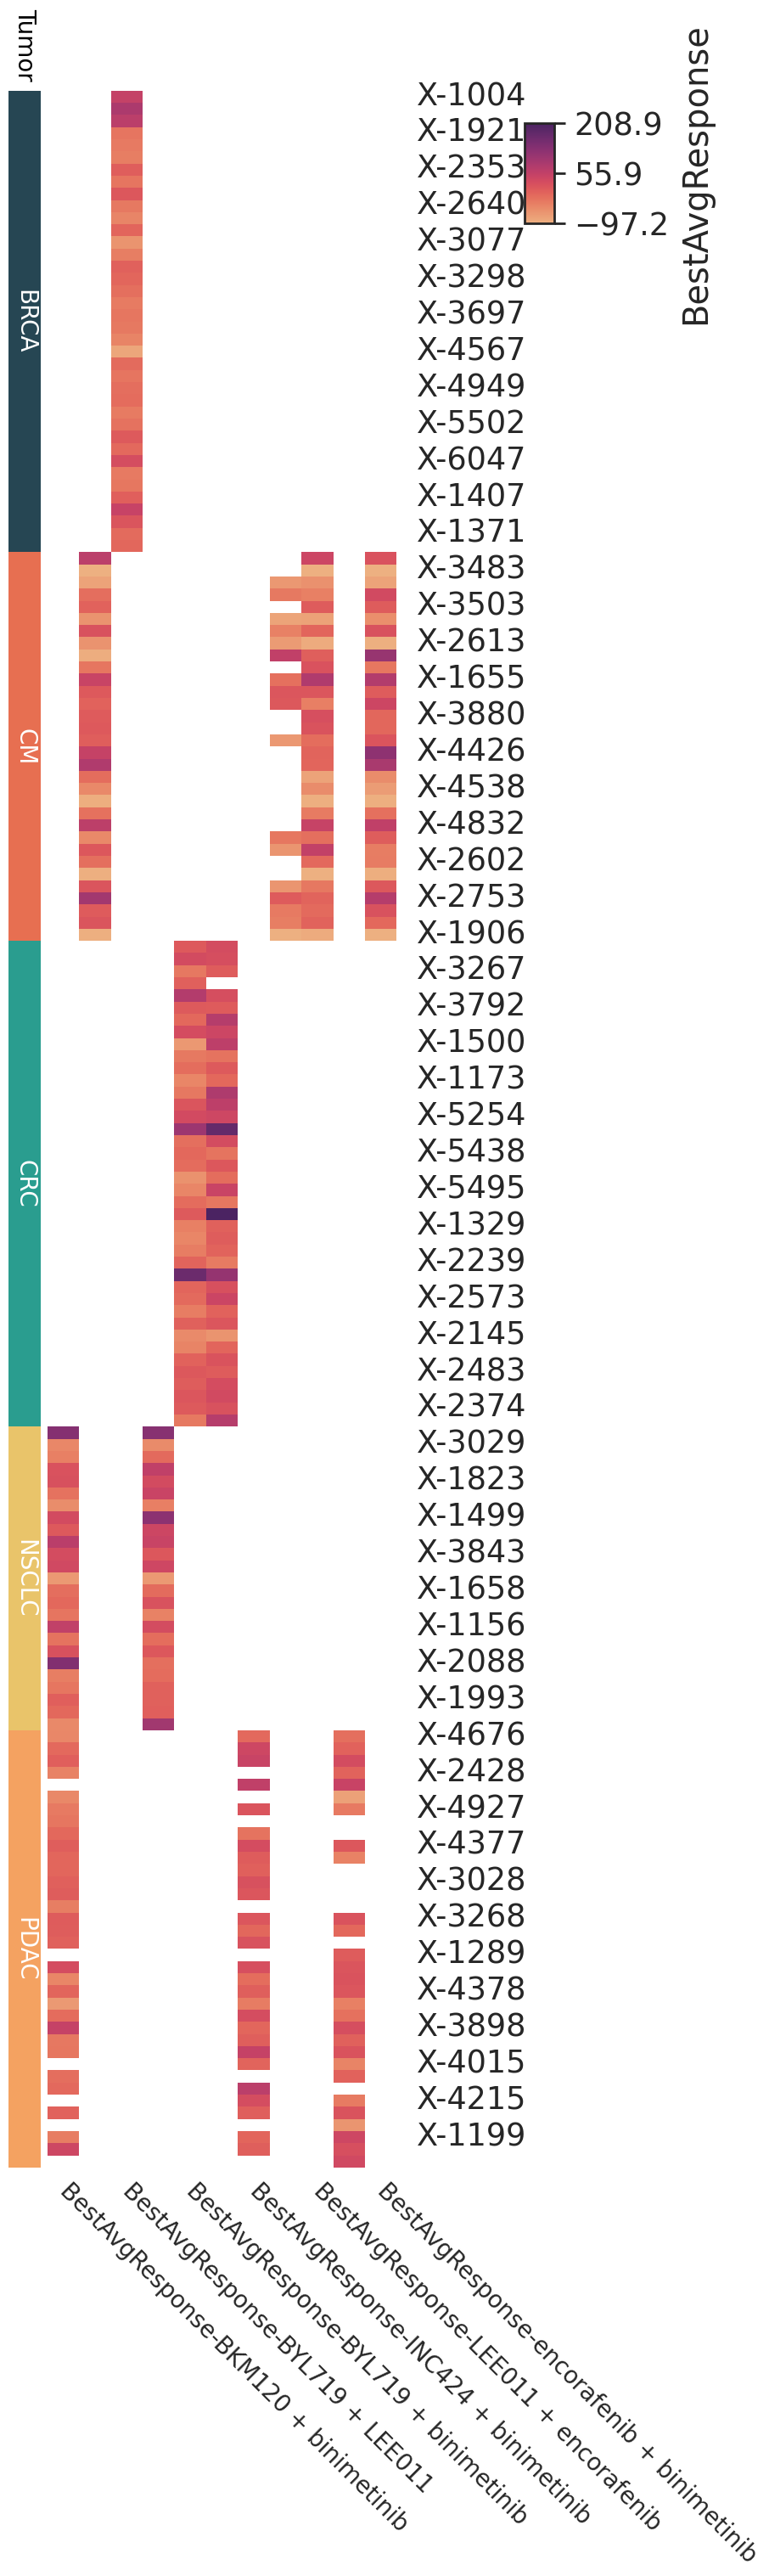

In [ ]:
import PyComplexHeatmap as pch

plot_data = X_metadata[["Model", "Treatment", "BestAvgResponse"]]
plot_data = pd.pivot_table(plot_data, values=["BestAvgResponse"], index="Model", columns="Treatment")
plot_data["tumor"] = [model_to_tumor.loc[model, "Tumor Type"] for model in plot_data.index]

colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
colors_dict = {tumor:color for tumor, color in zip(plot_data["tumor"].unique(), colors)}

row_ha_left = pch.HeatmapAnnotation(
    Tumor=pch.anno_simple(plot_data.sort_values("tumor")["tumor"], colors=colors_dict,
                             add_text=True, legend=False, height=5,
                             text_kws={'color':'white', 'fontsize':10,
                                       'rotation':-90, 'horizontalalignment':'center'}),
    label_kws={'fontsize':10, 'color':'black', 'rotation':-90, 'horizontalalignment':'right'},
    label_side="top", axis=0, verbose=0
)

plt.figure(figsize=(3, 14), dpi=200)
cm = pch.ClusterMapPlotter(data=plot_data.sort_values("tumor").drop(columns=["tumor"]), 
                           # z_score=0,
                           left_annotation=row_ha_left,
                           col_cluster=False, 
                           row_cluster=False,
                           label="BestAvgResponse", row_dendrogram=False,
                           col_dendrogram=False, 
                           show_rownames=True, show_colnames=True,
                           # row_split=plot_data["tumor"], row_split_gap=0.8,
                           cmap=sns.color_palette("flare", as_cmap=True),
                           xticklabels_kws={'labelrotation':-45, "labelsize":10, "label1On":True}
                          )

plt.savefig("../figs/fig7_pdx_data.svg", format="svg", dpi=300)
plt.show()

In [ ]:
torch.save({
    "X_metadata": X_metadata,
    "pdx_rnaseq_filtered": pdx_rnaseq_filtered,
    "pdx_rnaseq_filtered_hvg": pdx_rnaseq_filtered_hvg,
    "pdx_mut_filtered": pdx_mut_filtered,
    "pdx_drug_name_to_ind": pdx_drug_name_to_ind,
}, RAW_DATA_DIR+"processed_pdx_data_ready_for_ml.pt")

# Model-level predictions

In [ ]:
_, (
    X_metadata, 
    pdx_rnaseq_filtered, 
    pdx_rnaseq_filtered_hvg, 
    pdx_mut_filtered, 
    pdx_drug_name_to_ind,
) = zip(*torch.load(RAW_DATA_DIR+"processed_pdx_data_ready_for_ml.pt").items())

Check drug embeddings PCA explained variance ratio

In [ ]:
temp = torch.load(BASE_DIR+"model_output/DrugBank/split_by_pairs/snowy-serenity-8/drugbank_all_metadata_drug_embeddings_full.pt")
print(temp.shape)
pca = PCA(random_state=42)
temp_pca = pca.fit_transform(temp.numpy())

torch.Size([21842, 128])

In [85]:
np.cumsum(pca.explained_variance_ratio_)[:25]

array([0.30102634, 0.43206948, 0.54483074, 0.6362004 , 0.69230723,
       0.7451315 , 0.78572327, 0.81995165, 0.84998065, 0.8730107 ,
       0.895669  , 0.91212815, 0.92833424, 0.9413891 , 0.9524036 ,
       0.96050674, 0.9674309 , 0.9725513 , 0.9764661 , 0.9801488 ,
       0.98302513, 0.98540425, 0.98753536, 0.9888644 , 0.9900641 ],
      dtype=float32)

## Leave-one-drug-pair-out

### Prepare data

#### PCA for RNA-seq

In [22]:
pca = PCA(random_state=42)
pdx_rnaseq_filtered_pca = pca.fit_transform(pdx_rnaseq_filtered.to_df().values)
np.cumsum(pca.explained_variance_ratio_)[:25]

array([0.20456293, 0.27806612, 0.33394618, 0.37466878, 0.40773538,
       0.43215564, 0.45508788, 0.47449173, 0.4909379 , 0.5064853 ,
       0.52025635, 0.53301335, 0.54513648, 0.55610332, 0.56642723,
       0.5760057 , 0.58490698, 0.59371104, 0.60209409, 0.61036127,
       0.61765863, 0.62470353, 0.63158453, 0.63826123, 0.64479181])

In [6]:
pdx_rnaseq_filtered_pca = pdx_rnaseq_filtered_pca[:, :25]

#### MCA for Mutations

In [23]:
pdx_mut_filtered = pdx_mut_filtered.loc[:, (pdx_mut_filtered != 0).sum(0) > 2]
mca = prince.MCA(n_components=100, n_iter=10, check_input=True, copy=False, engine="sklearn", random_state=42, one_hot=True)
pdx_mut_filtered_mca = mca.fit_transform(pdx_mut_filtered)
mca.eigenvalues_summary.iloc[:25, :]

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.151,15.08%,15.08%
1,0.046,4.64%,19.71%
2,0.045,4.45%,24.17%
3,0.037,3.69%,27.85%
4,0.034,3.40%,31.26%
5,0.033,3.35%,34.60%
6,0.030,2.98%,37.58%
7,0.026,2.59%,40.17%
8,0.025,2.51%,42.68%


In [ ]:
pdx_mut_filtered_mca = pdx_mut_filtered_mca.iloc[:, :25]

#### Prepare all patient features

In [ ]:
assert (pdx_rnaseq_filtered.obs.index.values != pdx_mut_filtered_mca.index.values).sum() == 0

pdx_rnaseq_model_to_ind = {model: ind for ind, model in enumerate(pdx_rnaseq_filtered.obs.index)}
X_model_rnaseq_pca = pdx_rnaseq_filtered_pca[[pdx_rnaseq_model_to_ind[model] for model in X_metadata["Model"]], :]
X_model_mut_mca = pdx_mut_filtered_mca.values[[pdx_rnaseq_model_to_ind[model] for model in X_metadata["Model"]], :]

In [ ]:
torch.save({
    "pdx_rnaseq_model_to_ind": pdx_rnaseq_model_to_ind,
    "X_model_rnaseq_pca": X_model_rnaseq_pca,
    "X_model_mut_mca": X_model_mut_mca,
}, RAW_DATA_DIR+"processed_pdx_data_ready_for_ml_splitted.pt")

### Regression

#### Load data

In [ ]:
_, (
    pdx_rnaseq_model_to_ind, 
    X_model_rnaseq_pca, 
    X_model_mut_mca, 
) = zip(*torch.load(RAW_DATA_DIR+"processed_pdx_data_ready_for_ml_splitted.pt").items())

Outcome: Can be either `BestAvgResponse` or `TimeToDouble`

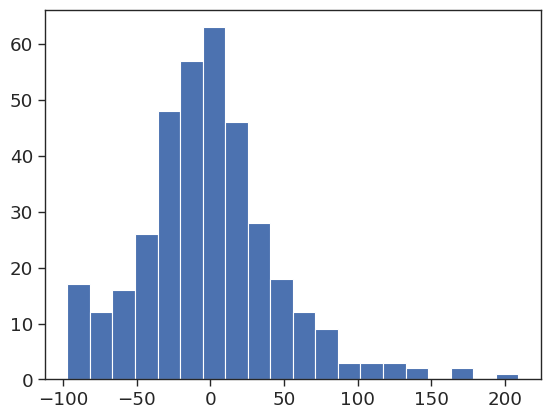

In [ ]:
y_cont = X_metadata["BestAvgResponse"].values
# y_cont = X_metadata["TimeToDouble"].values
plt.hist(y_cont, ec="white", bins=20)
plt.show()

In [ ]:
from scipy.stats import kendalltau, pearsonr

all_drug_pairs_patient_scores = {}
all_pearsonr_perfs = {}
all_spearmanr_perfs = {}
all_kendalltau_perfs = {}

for drug_pair_test in X_metadata["Treatment"].unique():
    # drug_1, drug_2 = drug_pair_test.split(" + ")
    test_indicator_leave_one_drug_pair_out = X_metadata["Treatment"].values == drug_pair_test
    train_indicator_leave_one_drug_pair_out = ~test_indicator_leave_one_drug_pair_out
    
    y_cont_train = y_cont[train_indicator_leave_one_drug_pair_out]
    y_cont_test = y_cont[test_indicator_leave_one_drug_pair_out]
    
    print(drug_pair_test)
    
    drug_pair_patient_scores = []
    pearsonr_perfs = []
    spearmanr_perfs = []
    kendalltau_perfs = []
        
    for run_name in [
        "snowy-serenity-8", 
        "revived-aardvark-8", 
        "whole-fog-7", 
        "misty-oath-5", 
        "drawn-grass-4", 
    ]:
        print(f"\tWorking on ckpt: {run_name}")
        drug_embeds = torch.load(BASE_DIR+f"model_output/DrugBank/split_by_pairs/{run_name}/drugbank_all_metadata_drug_embeddings_full.pt")[:drug_metadata[~drug_metadata["node_id"].isna()].index.max()+1]
        pca = PCA(random_state=42)
        drug_embeds_pca = pca.fit_transform(drug_embeds.numpy())
        drug_embeds_pca = drug_embeds_pca[:, :25]  # already explains 95% variance

        X_drug_1_embeds_pca = drug_embeds_pca[X_metadata["drug_1_ind"].values]
        X_drug_2_embeds_pca = drug_embeds_pca[X_metadata["drug_2_ind"].values]
        X_drug_embeds_pca_max = np.max(np.stack([X_drug_1_embeds_pca, X_drug_2_embeds_pca], axis=-1), axis=-1)

        X_full = np.concatenate([
            X_model_rnaseq_pca, 
            X_model_mut_mca, 
            X_drug_embeds_pca_max, 
        ], axis=1)

        X_full_test = X_full[test_indicator_leave_one_drug_pair_out]
        X_full_train = X_full[train_indicator_leave_one_drug_pair_out]

        for seed in [0, 1, 2, 42, 99]:
            print(f"\t\tSeed {str(seed)}")
            clf = RandomForestRegressor(
                n_estimators=1000, criterion="friedman_mse", max_depth=None, min_samples_split=2, max_features=1.0,
                n_jobs=-1, random_state=seed)
            
            clf.fit(X_full_train, y_cont_train)
            preds_test = clf.predict(X_full_test)
            
            drug_pair_patient_scores.append(preds_test)
            pearsonr_perfs.append(pearsonr(preds_test, y_cont_test))
            spearmanr_perfs.append(spearmanr(preds_test, y_cont_test))
            kendalltau_perfs.append(kendalltau(preds_test, y_cont_test))
    
    drug_pair_patient_scores = np.stack(drug_pair_patient_scores, axis=0).mean(axis=0)
    all_drug_pairs_patient_scores[drug_pair_test] = dict(zip(X_metadata["Model"][test_indicator_leave_one_drug_pair_out].values, 
                                                             drug_pair_patient_scores))
    all_pearsonr_perfs[drug_pair_test] = pearsonr_perfs
    all_spearmanr_perfs[drug_pair_test] = spearmanr_perfs
    all_kendalltau_perfs[drug_pair_test] = kendalltau_perfs

#### response, RF

In [74]:
perf_table = pd.DataFrame({k: (np.mean([vv.statistic for vv in v]), np.mean([vv.pvalue for vv in v])) for k, v in all_kendalltau_perfs.items()}).T
perf_table.columns = ["correlation", "p-value"]
perf_table

,correlation,p-value
BYL719 + LEE011,0.021110,8.414576e-01
BYL719 + encorafenib,0.307422,6.063649e-03
BYL719 + binimetinib,0.327077,3.245441e-03
BKM120 + binimetinib,0.423731,6.558267e-06
BYL719 + LGH447,0.477867,7.100914e-04
abraxane + gemcitabine,0.201693,1.546997e-01
INC424 + binimetinib,0.228995,9.449092e-02
BKM120 + encorafenib,0.613226,1.427674e-07
LEE011 + encorafenib,0.517581,1.469737e-05
LEE011 + binimetinib,0.466471,8.959834e-03


In [172]:
# all_drug_pairs_patient_scores_response_target = all_drug_pairs_patient_scores.copy()
# torch.save(all_drug_pairs_patient_scores_response_target, "all_drug_pairs_patient_scores_response_target.pkl")

In [ ]:
all_drug_pairs_patient_scores_response_target = torch.load("all_drug_pairs_patient_scores_response_target.pkl")

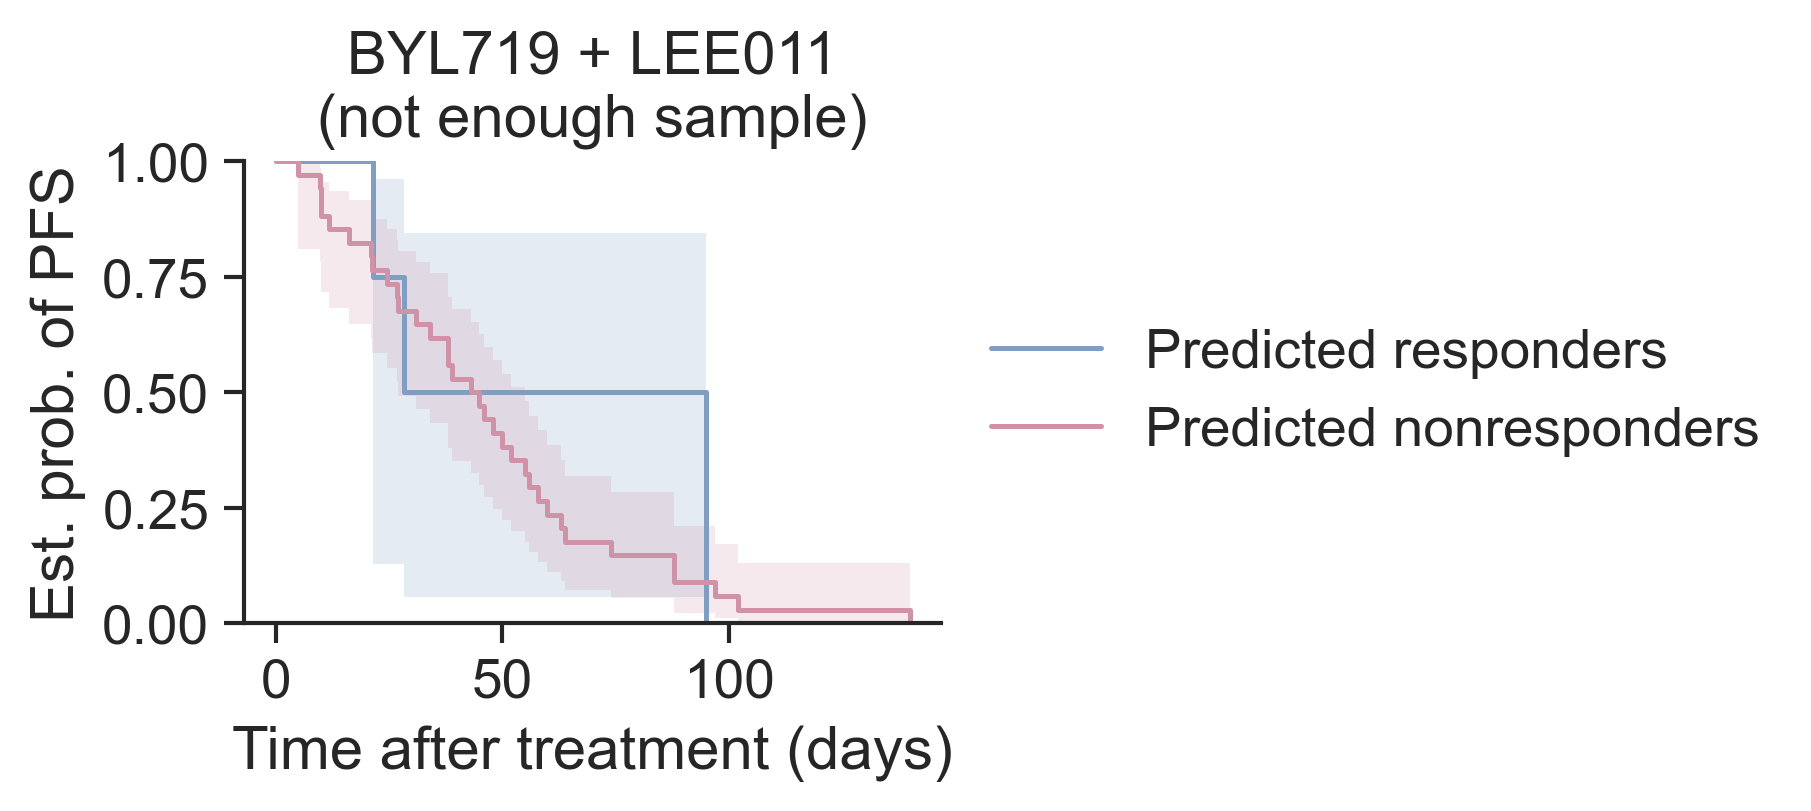

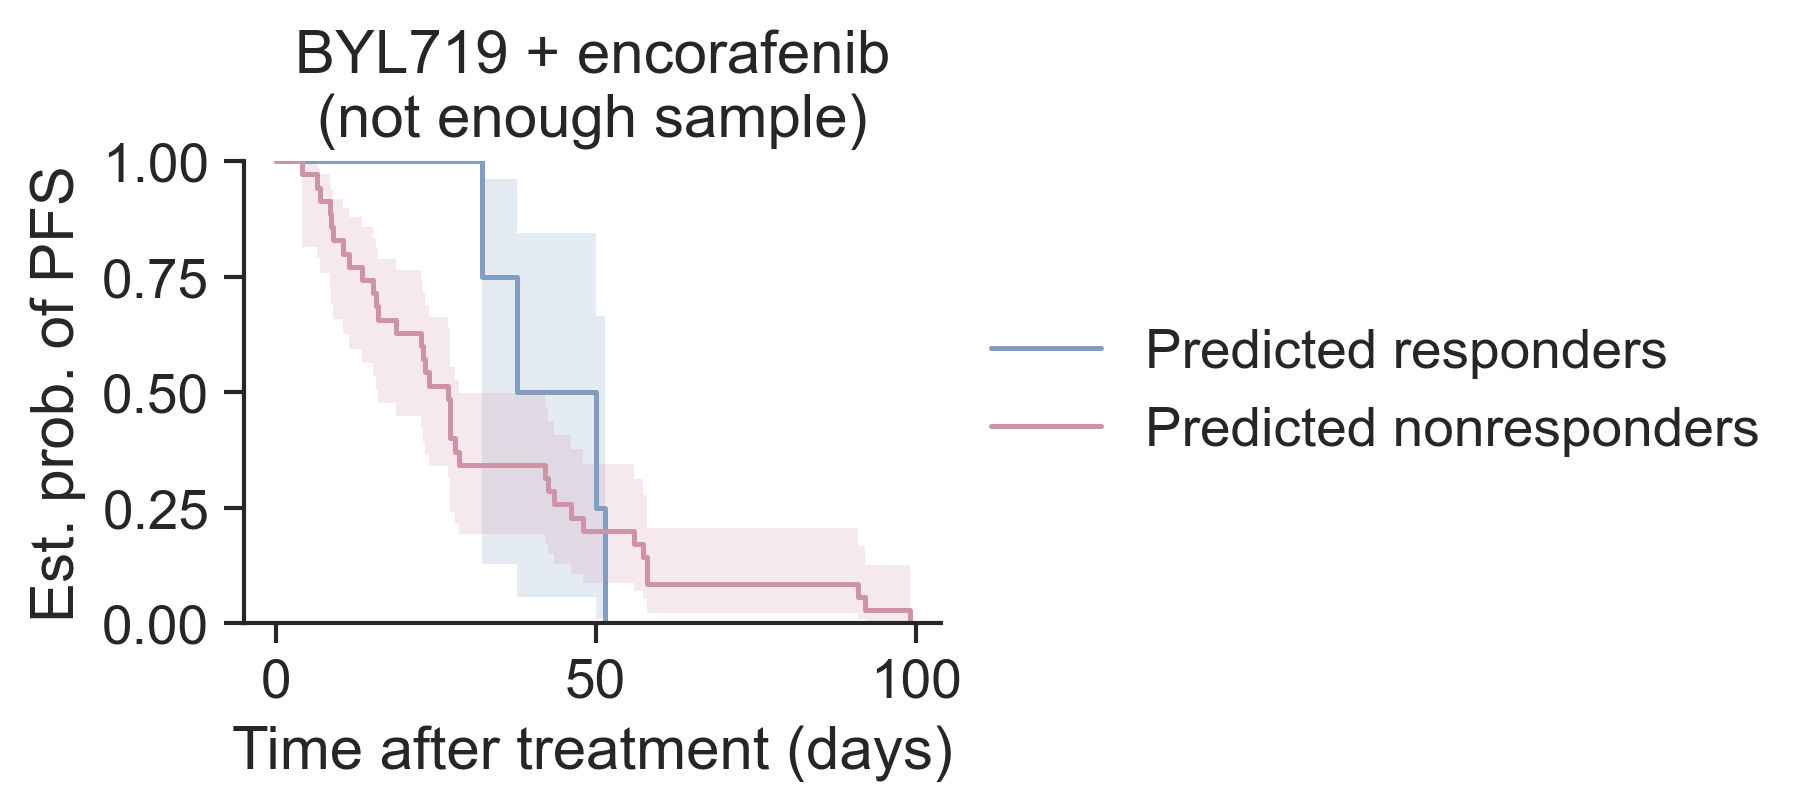

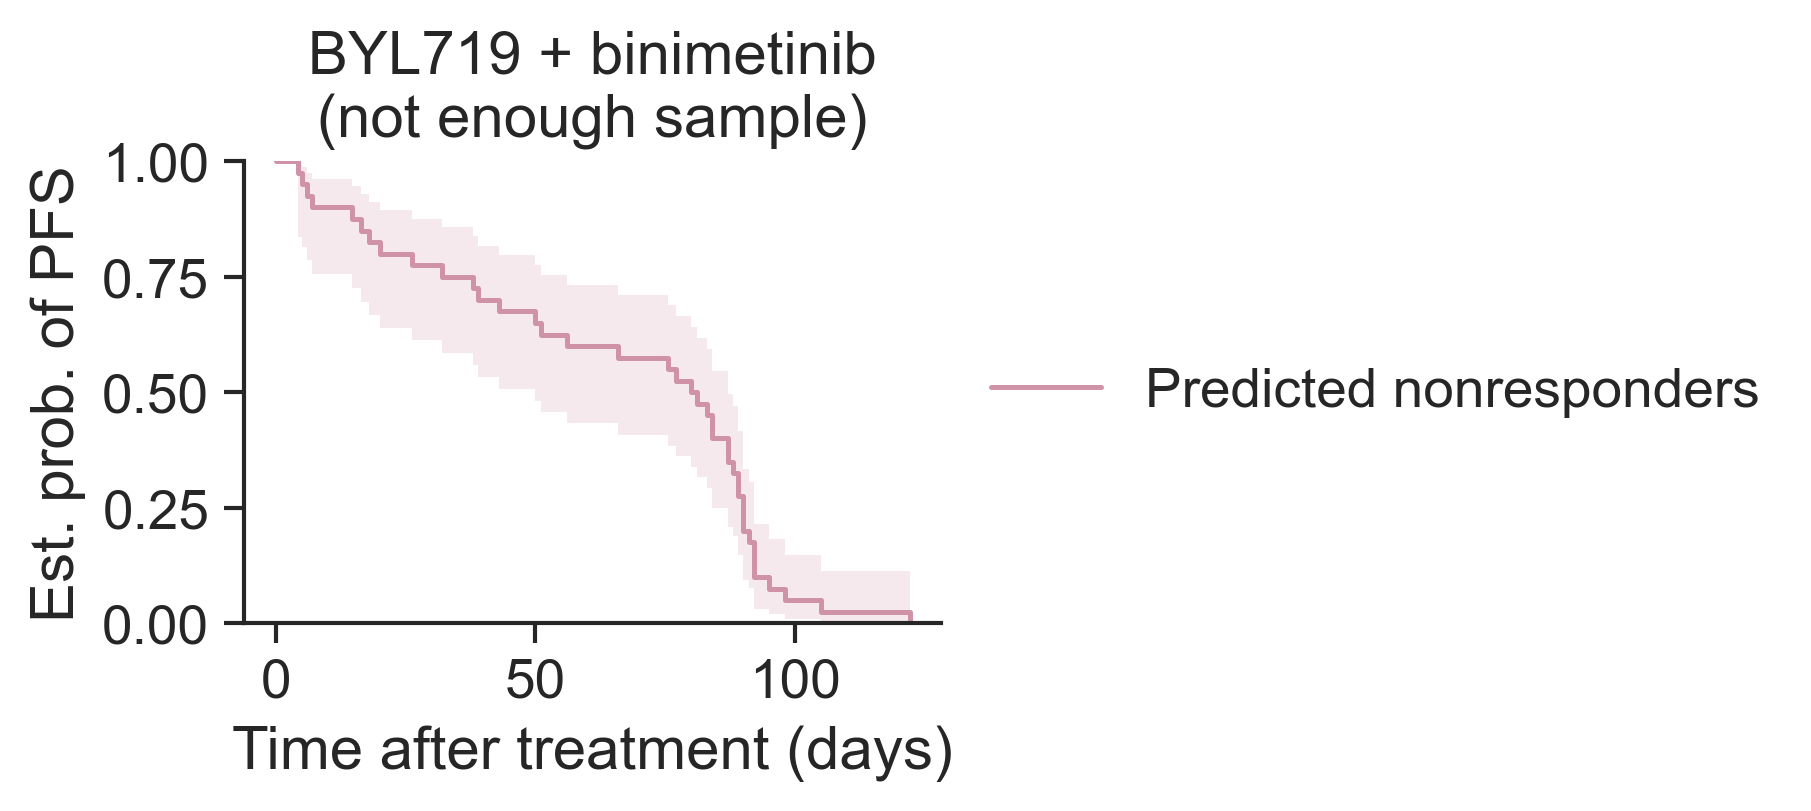

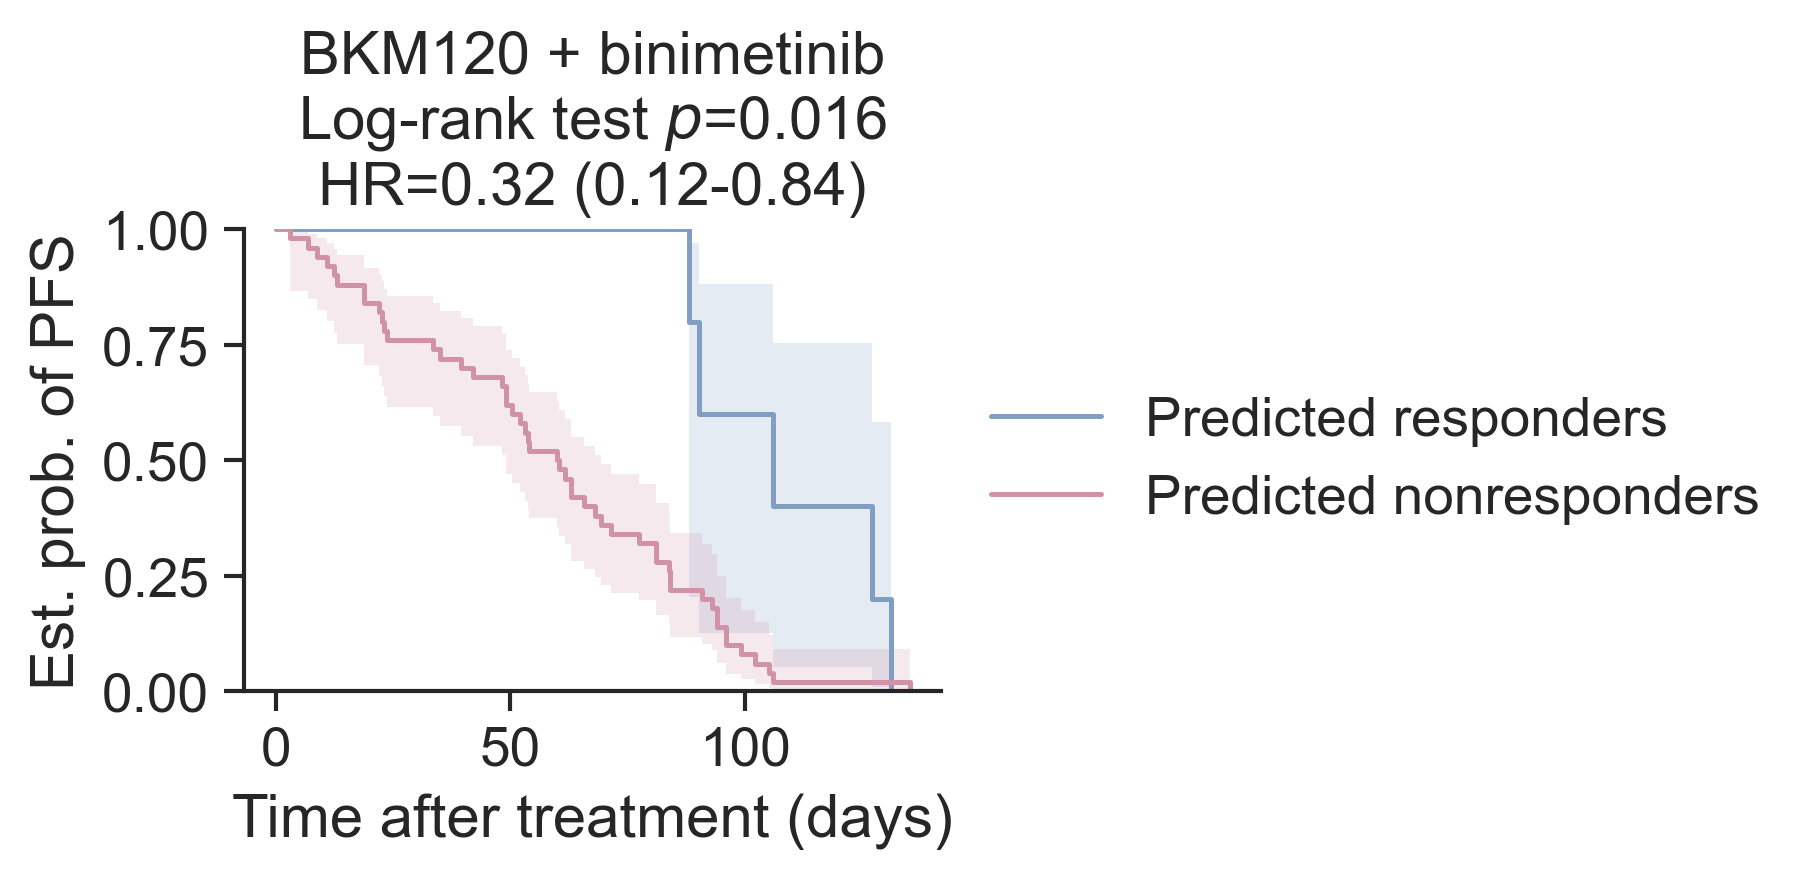

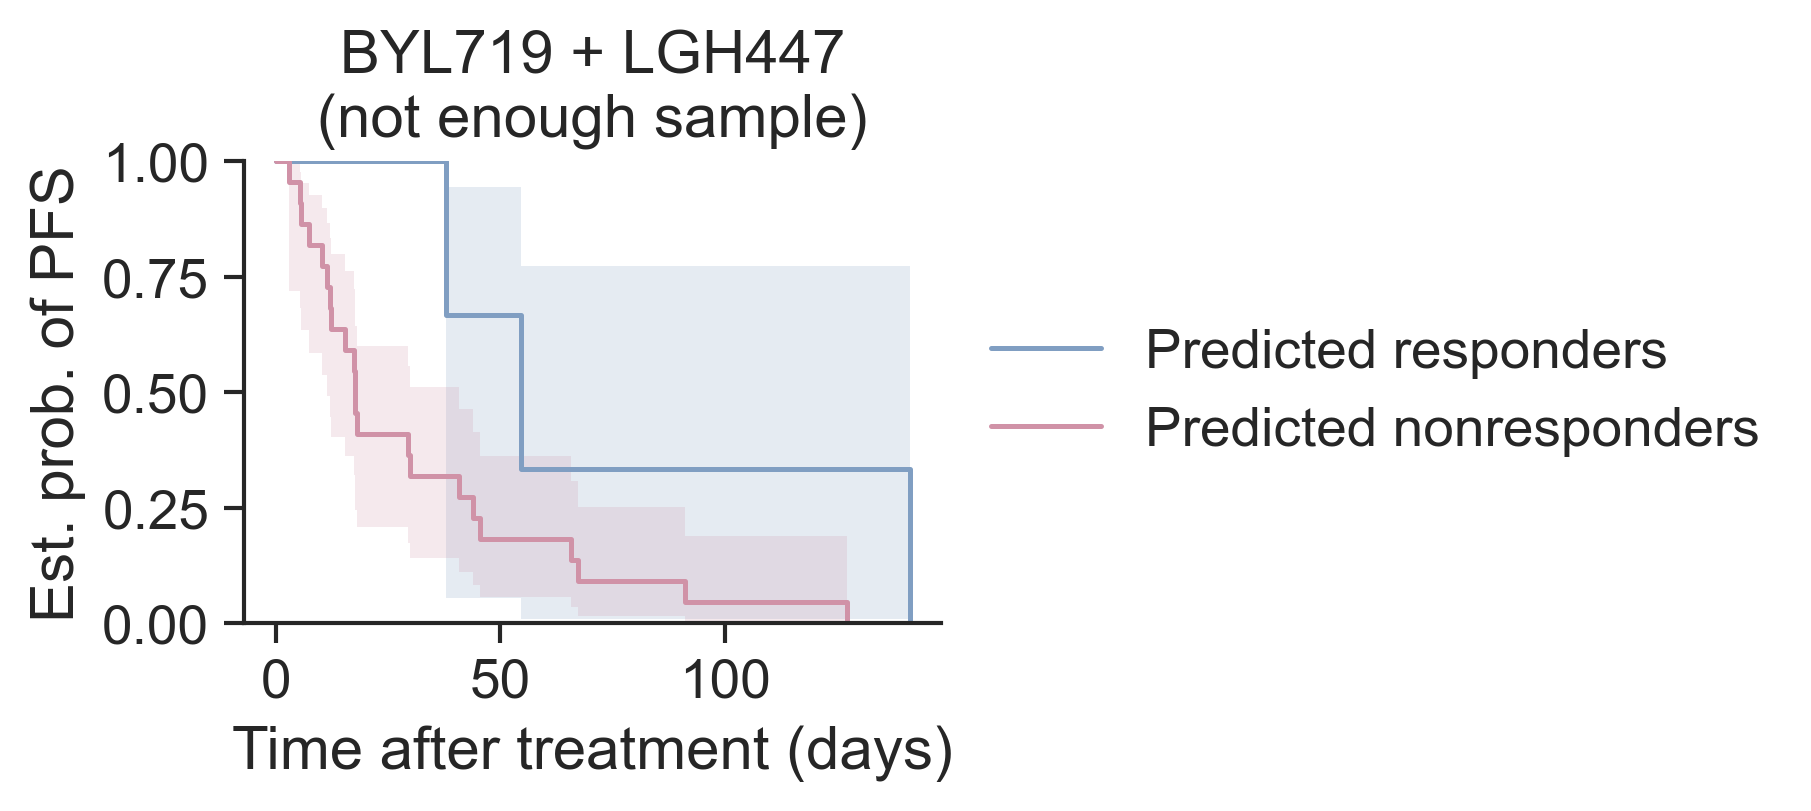

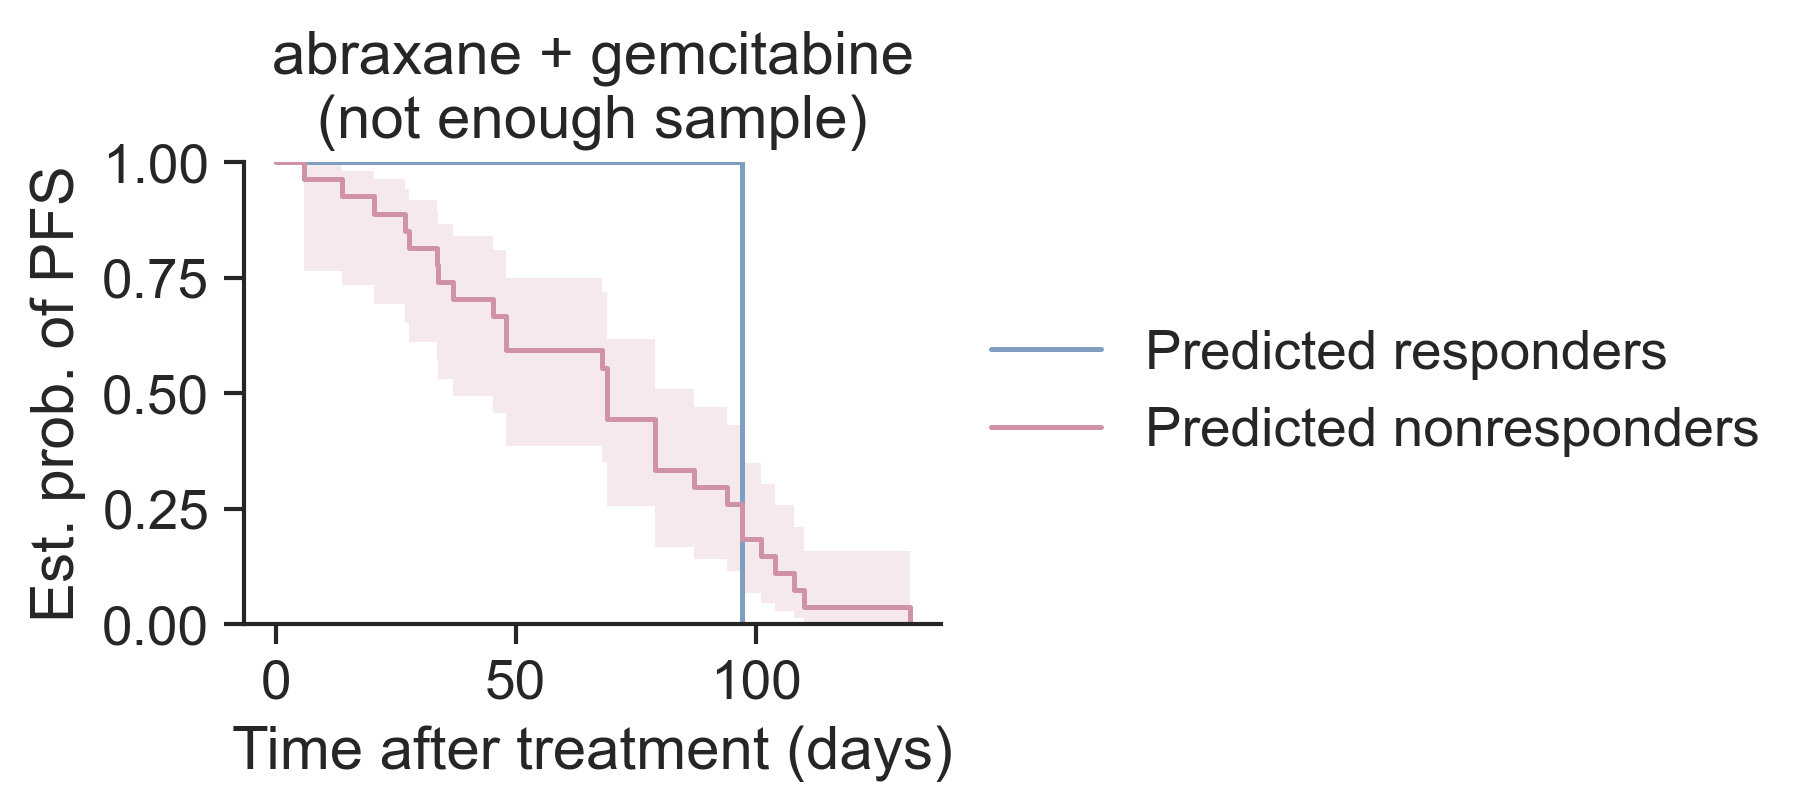

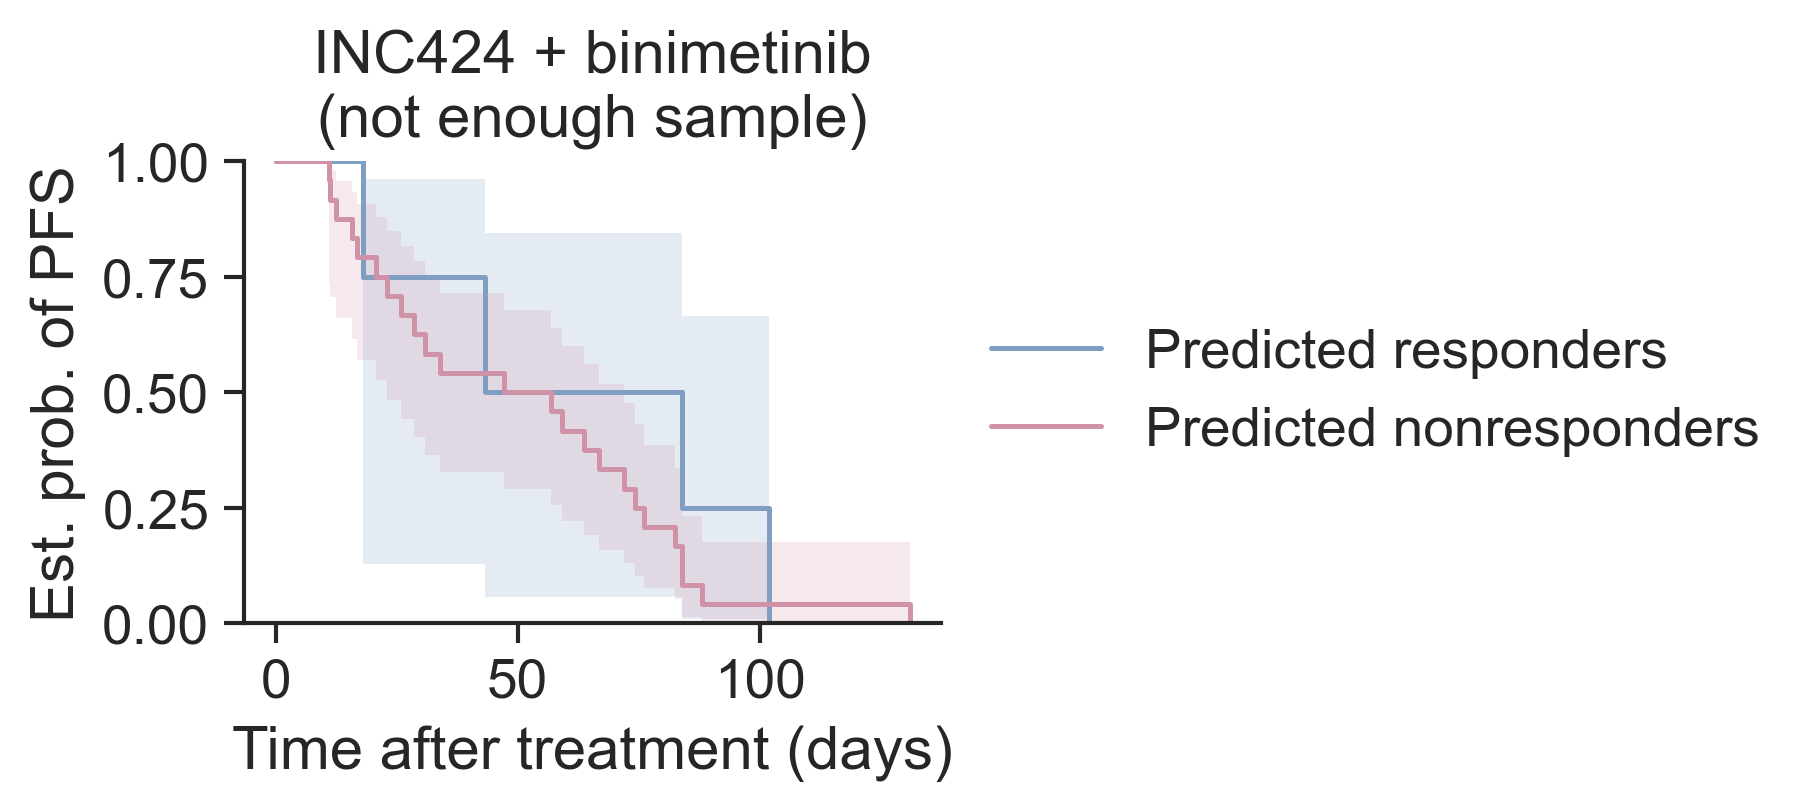

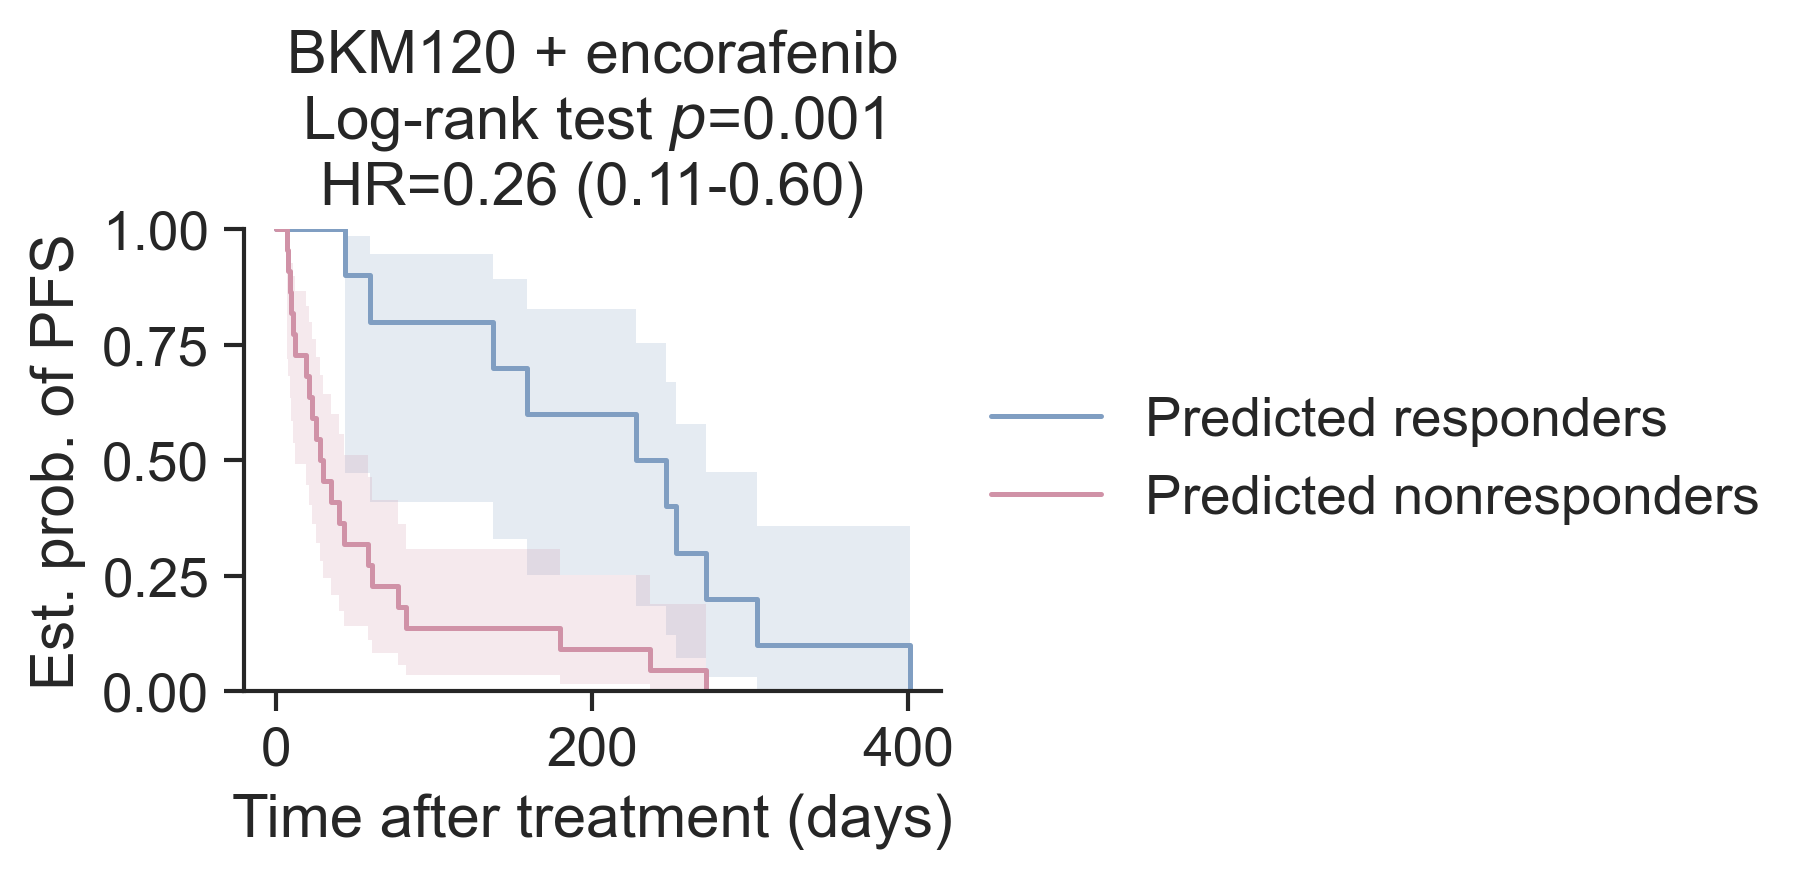

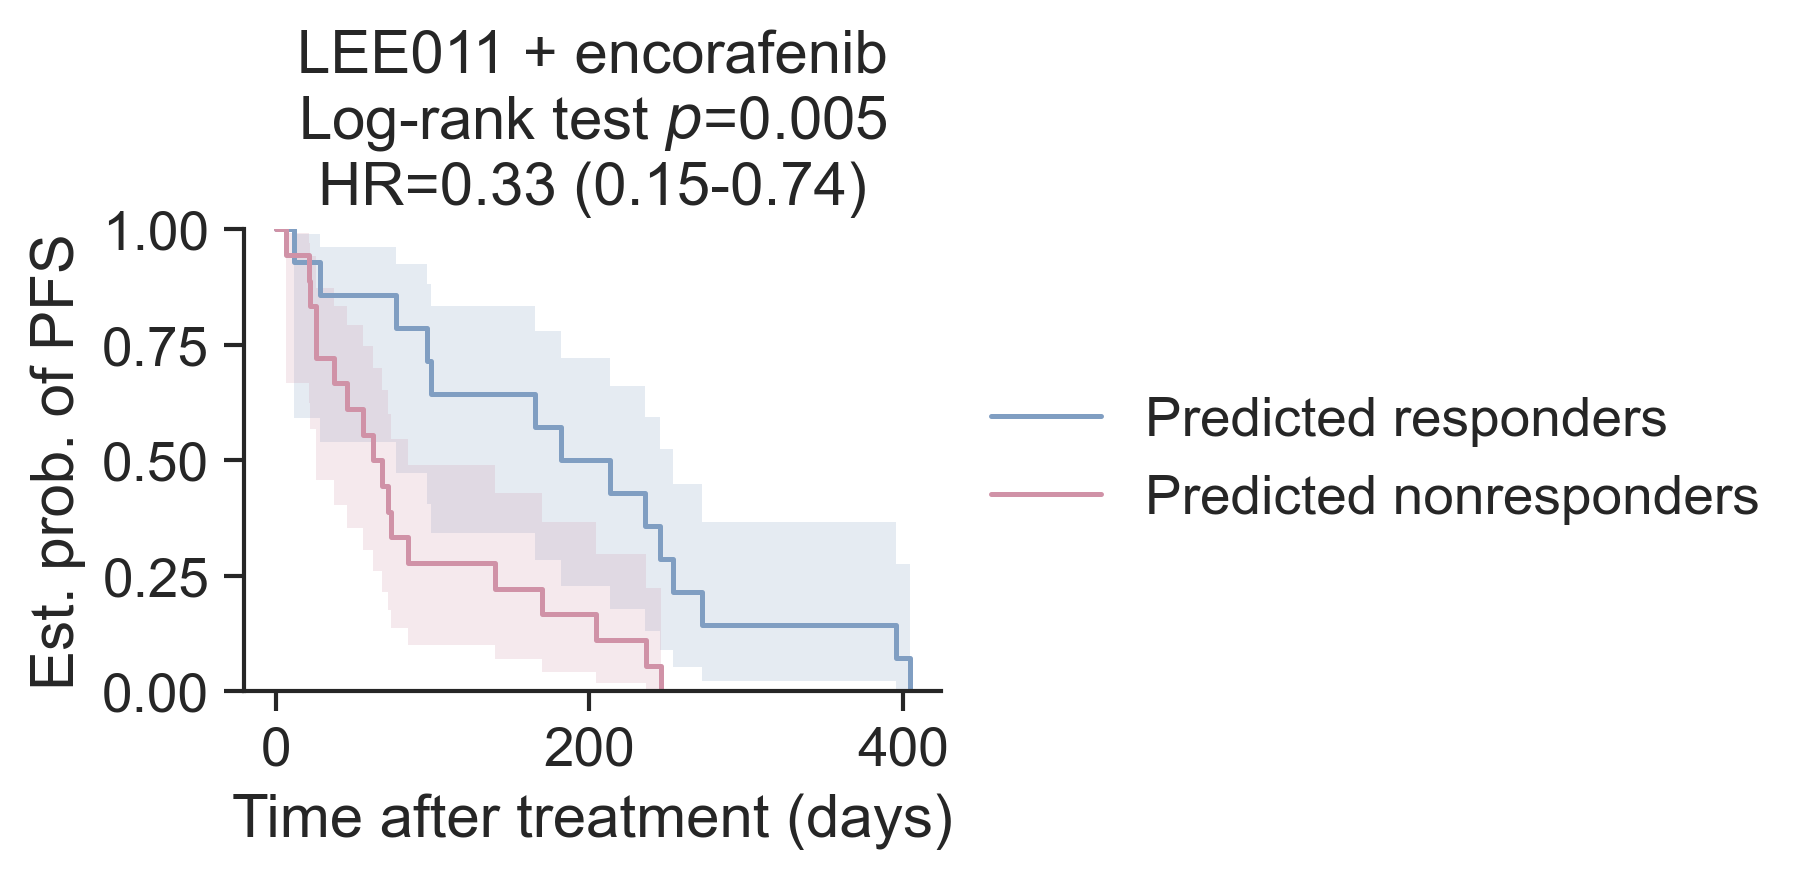

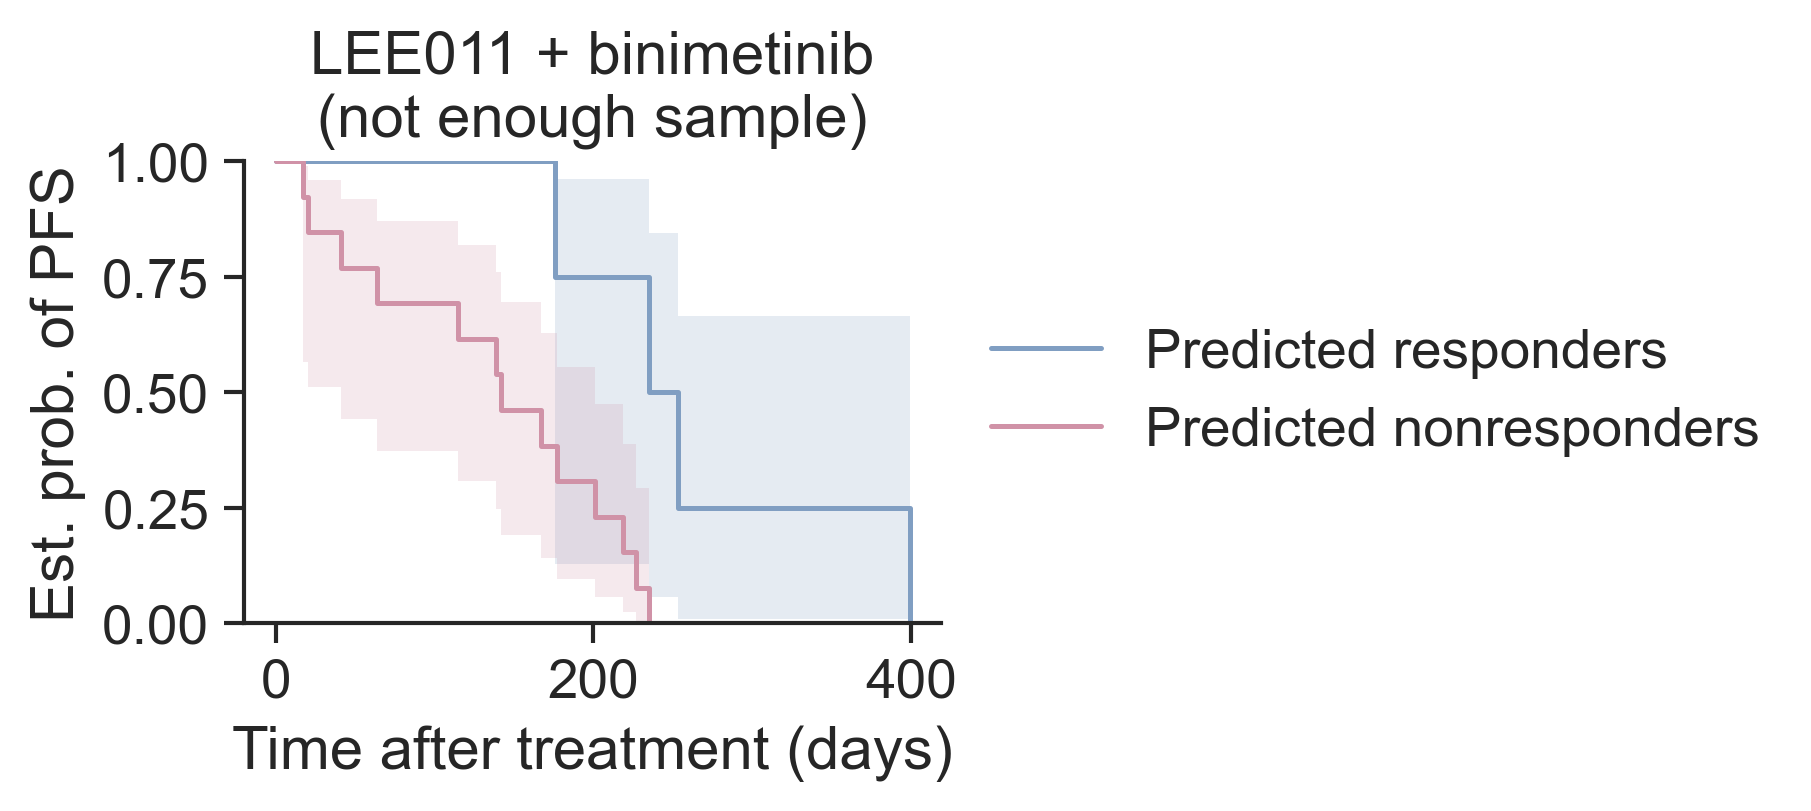

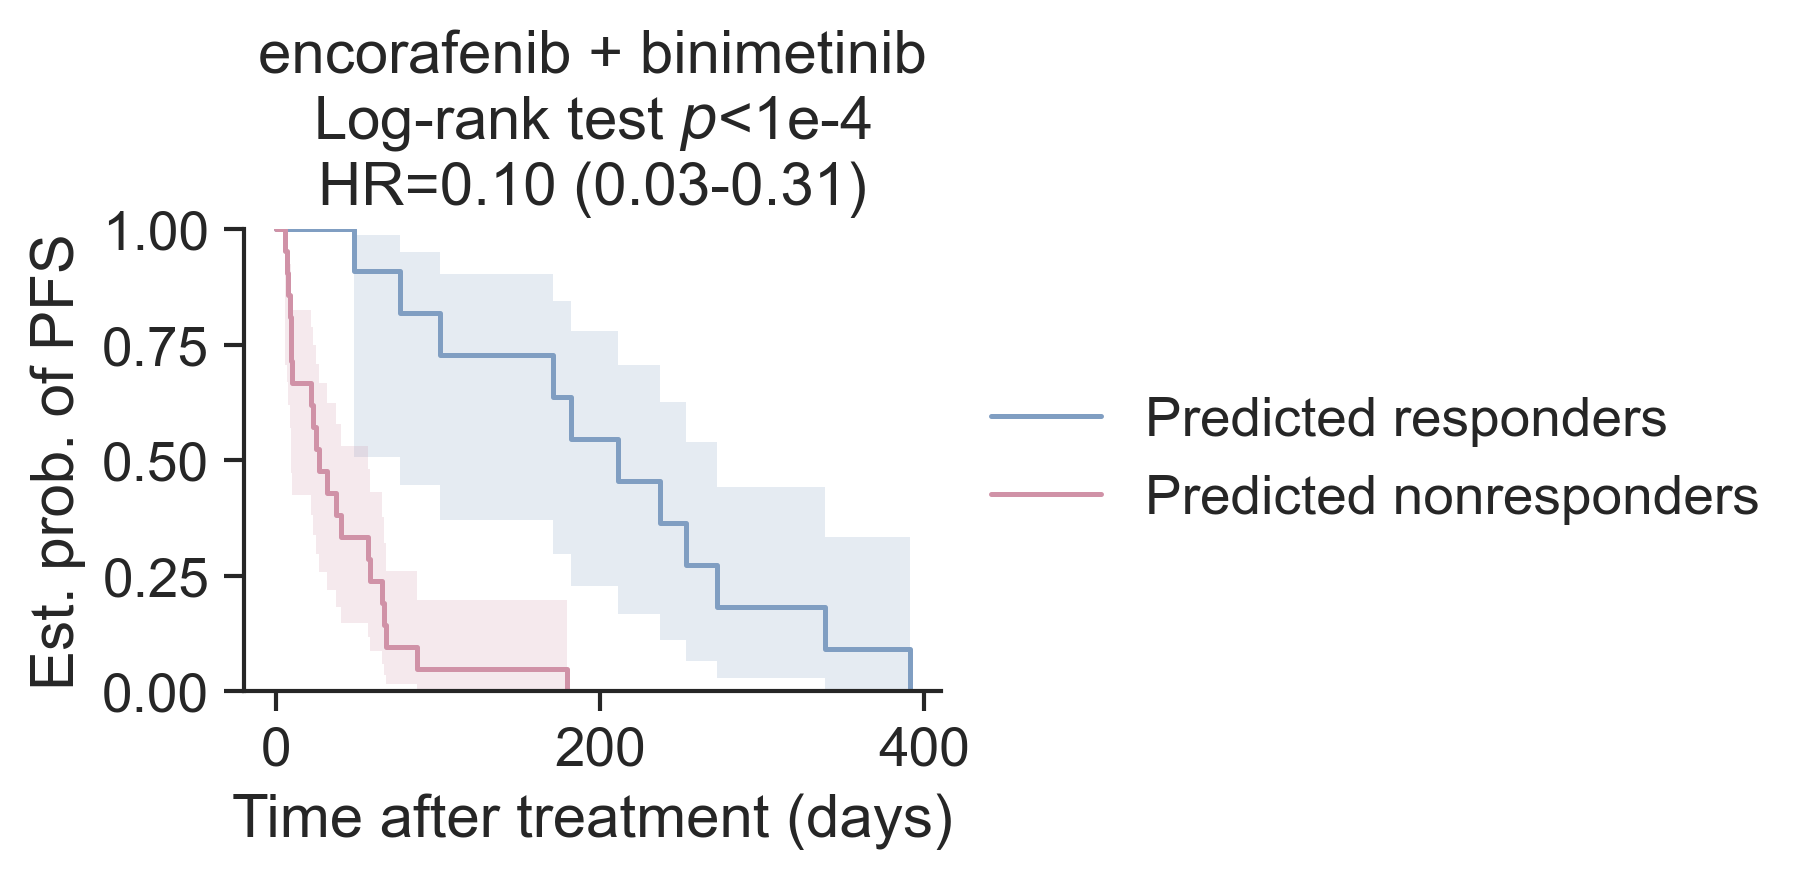

In [ ]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# from sksurv.compare import compare_survival

from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

predicted_outcome = "BestAvgResponse"
pfs_col = "TimeToDouble"

for drug_pair, dct in all_drug_pairs_patient_scores_response_target.items():
    patients = list(dct.keys())
    pred_scores = np.array(list(dct.values()))
    pred_respond = pred_scores < -20
    mask = pred_respond
    pfs = X_metadata[["Model", "Treatment", pfs_col]].set_index(["Model", "Treatment"]).loc[(patients, drug_pair), pfs_col]
    
    _, ax = plt.subplots(figsize=(3, 2), dpi=300)
    sns.set(context="paper", style="ticks", font_scale=1.5)

    kmf = KaplanMeierFitter()
    if mask.sum() > 0:
        kmf.fit(durations = pfs[mask], event_observed = np.array([True] * mask.sum()), label = "Predicted responders")
        kmf.plot_survival_function(ax = ax, ci_alpha = 0.2, ci_no_lines = True, color = "#809ec2")
    if (~mask).sum() > 0:
        kmf.fit(durations = pfs[~mask], event_observed = np.array([True] * (~mask).sum()), label = "Predicted nonresponders")
        kmf.plot_survival_function(ax = ax, ci_alpha = 0.2, ci_no_lines = True, color = "#d092a7")
        
    if pred_respond.sum() >= 5 and (1 - pred_respond).sum() >= 5:
        results = logrank_test(pfs[mask], pfs[~mask], 
                               event_observed_A=np.array([True] * mask.sum()), event_observed_B=np.array([True] * (~mask).sum()))
        
        df = pd.DataFrame({
            "time": pfs,
            "event": np.ones_like(pfs, dtype=int),   # 1 = event occurred
            "group": mask.astype(int)                # 1 = mask True, 0 = mask False
        })

        cph = CoxPHFitter()
        cph.fit(df, duration_col="time", event_col="event")
        hr = cph.summary["exp(coef)"].values[0]
        hr_ci_lower_95 = cph.summary["exp(coef) lower 95%"].values[0]
        hr_ci_higher_95 = cph.summary["exp(coef) upper 95%"].values[0]
        
        if results.p_value >= 0.0005:
            plt.title(drug_pair+"\n"+r"Log-rank test $p$="+f"{results.p_value:.3f}"+"\n"+f"HR={hr:.2f} ({hr_ci_lower_95:.2f}-{hr_ci_higher_95:.2f})")
        else:
            assert results.p_value < 0.0001
            plt.title(drug_pair+"\n"+r"Log-rank test $p$<1e-4"+"\n"+f"HR={hr:.2f} ({hr_ci_lower_95:.2f}-{hr_ci_higher_95:.2f})")

    else:
        plt.title(drug_pair+"\n(not enough sample)")
        
    plt.ylim(0, 1)
    plt.ylabel("Est. prob. of PFS")
    plt.xlabel("Time after treatment (days)")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    sns.despine()
    
    plt.savefig(f"./fig7_pdx_survival_pr_cr_vs_pd_sd_{drug_pair}.svg", format="svg", dpi=300)
    plt.show()


#### PFS, RF

In [149]:
perf_table = pd.DataFrame({k: (np.mean([vv.statistic for vv in v]), np.mean([vv.pvalue for vv in v])) for k, v in all_kendalltau_perfs.items()}).T
perf_table.columns = ["correlation", "p-value"]
perf_table

,correlation,p-value
BYL719 + LEE011,-0.008211,0.865256
BYL719 + encorafenib,0.444673,0.000076
BYL719 + binimetinib,0.508532,0.000005
BKM120 + binimetinib,0.171386,0.166847
BYL719 + LGH447,0.407200,0.004624
abraxane + gemcitabine,0.084297,0.536798
INC424 + binimetinib,0.166057,0.224318
BKM120 + encorafenib,0.597135,0.000002
LEE011 + encorafenib,0.527581,0.000048
LEE011 + binimetinib,0.421848,0.019171


In [175]:
# all_drug_pairs_patient_scores_pfs_target = all_drug_pairs_patient_scores.copy()
# torch.save(all_drug_pairs_patient_scores_pfs_target, "all_drug_pairs_patient_scores_pfs_target.pkl")

In [28]:
all_drug_pairs_patient_scores_pfs_target = torch.load("all_drug_pairs_patient_scores_pfs_target.pkl")

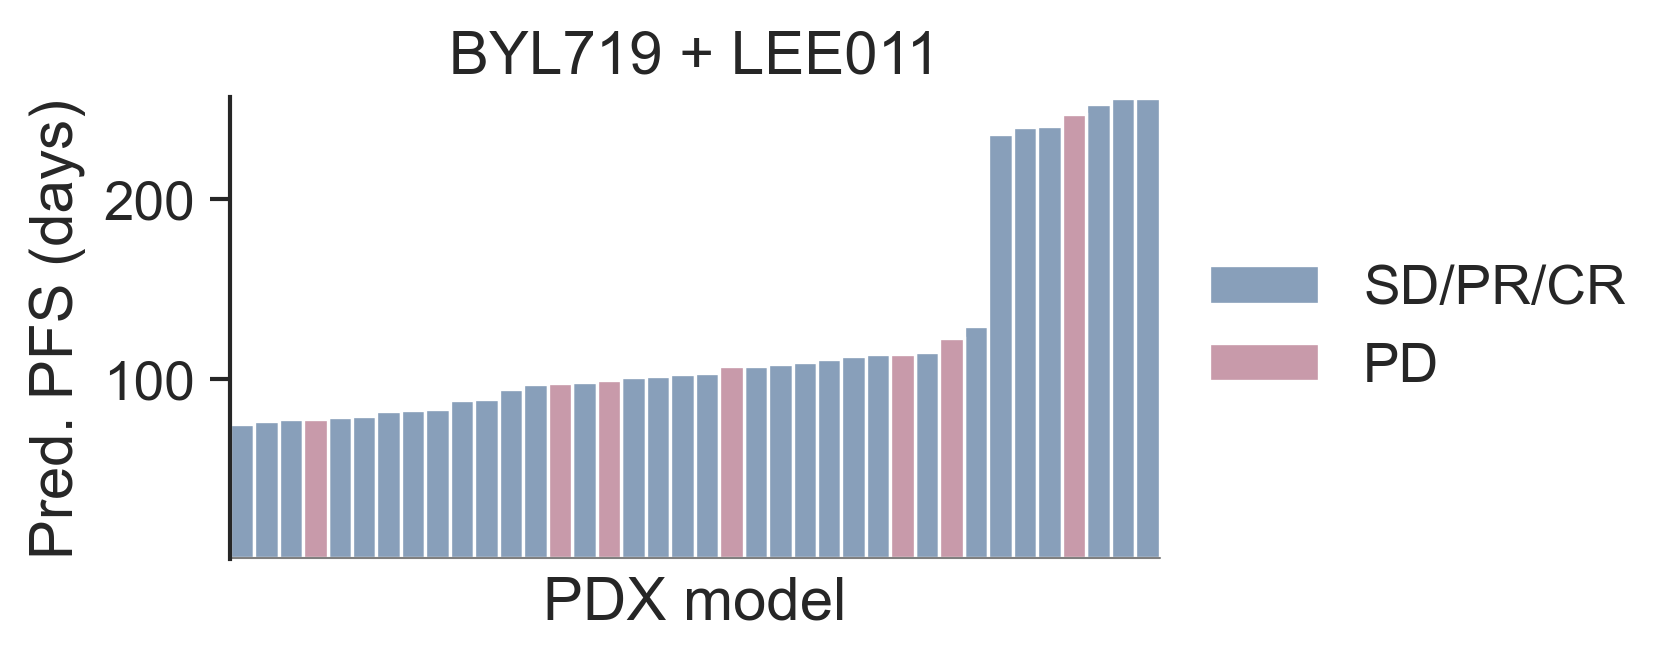

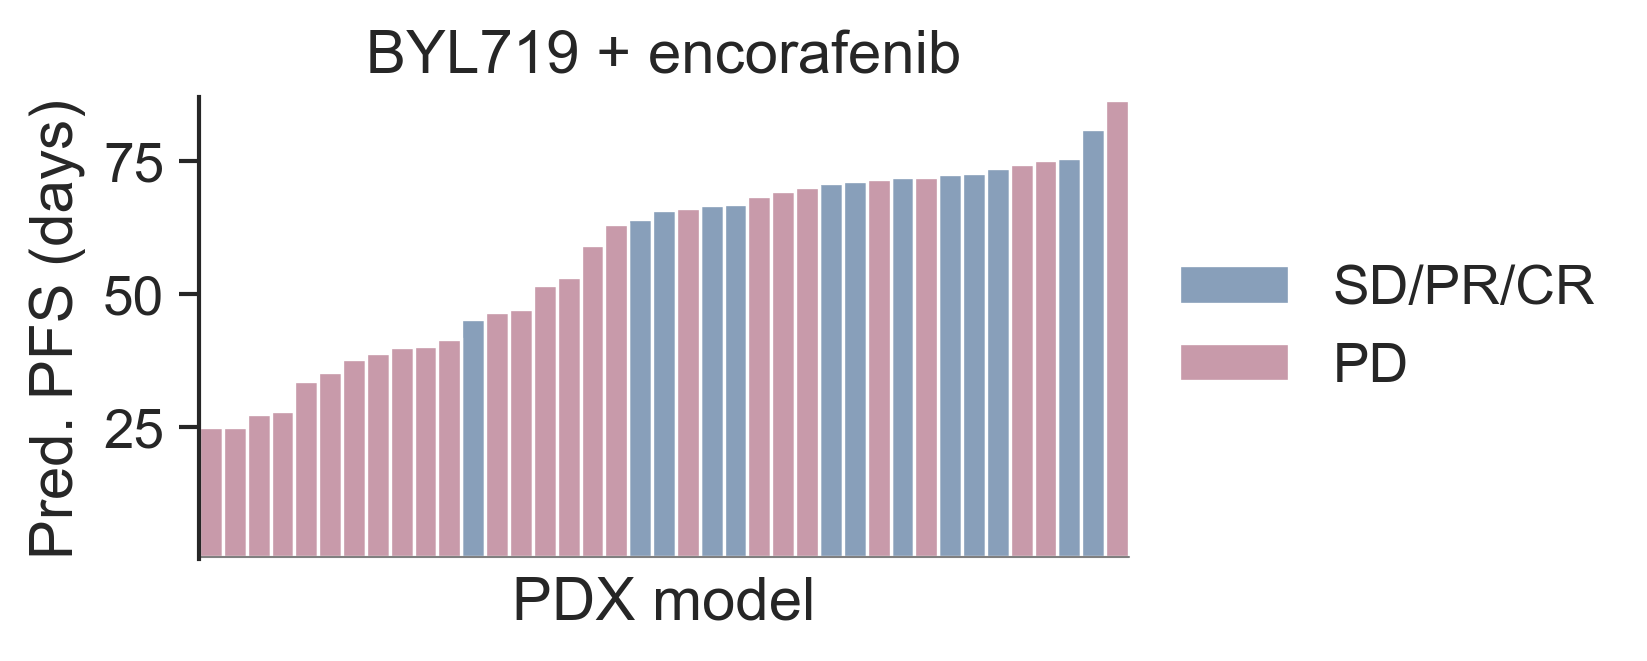

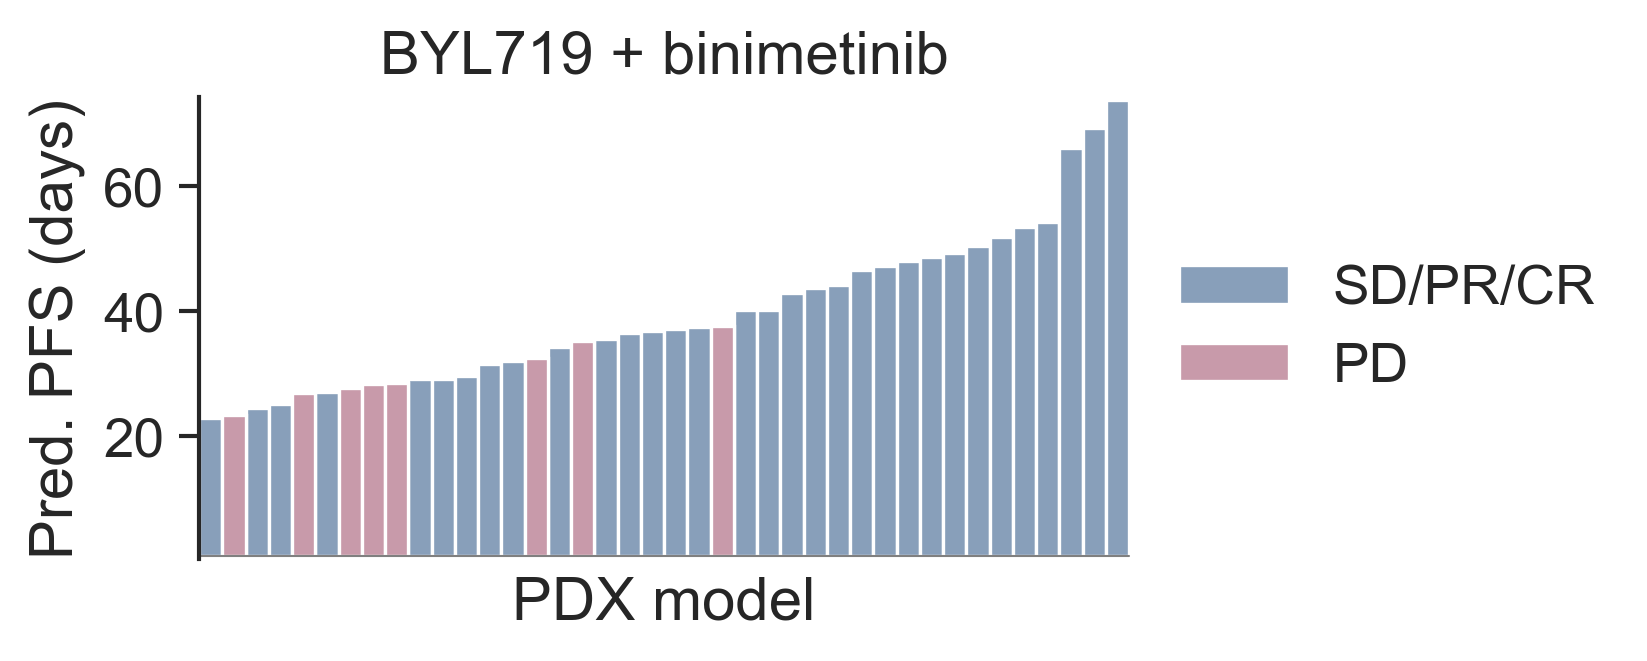

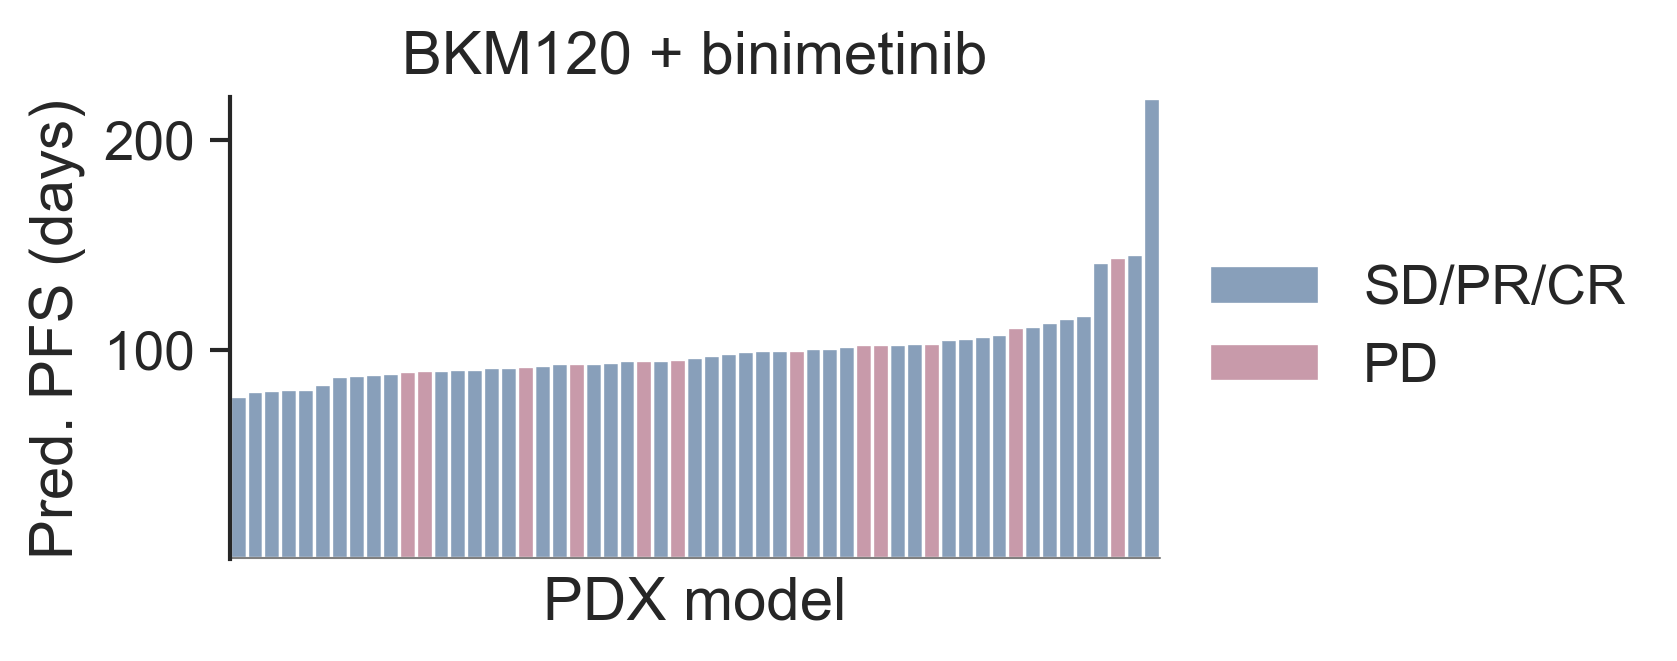

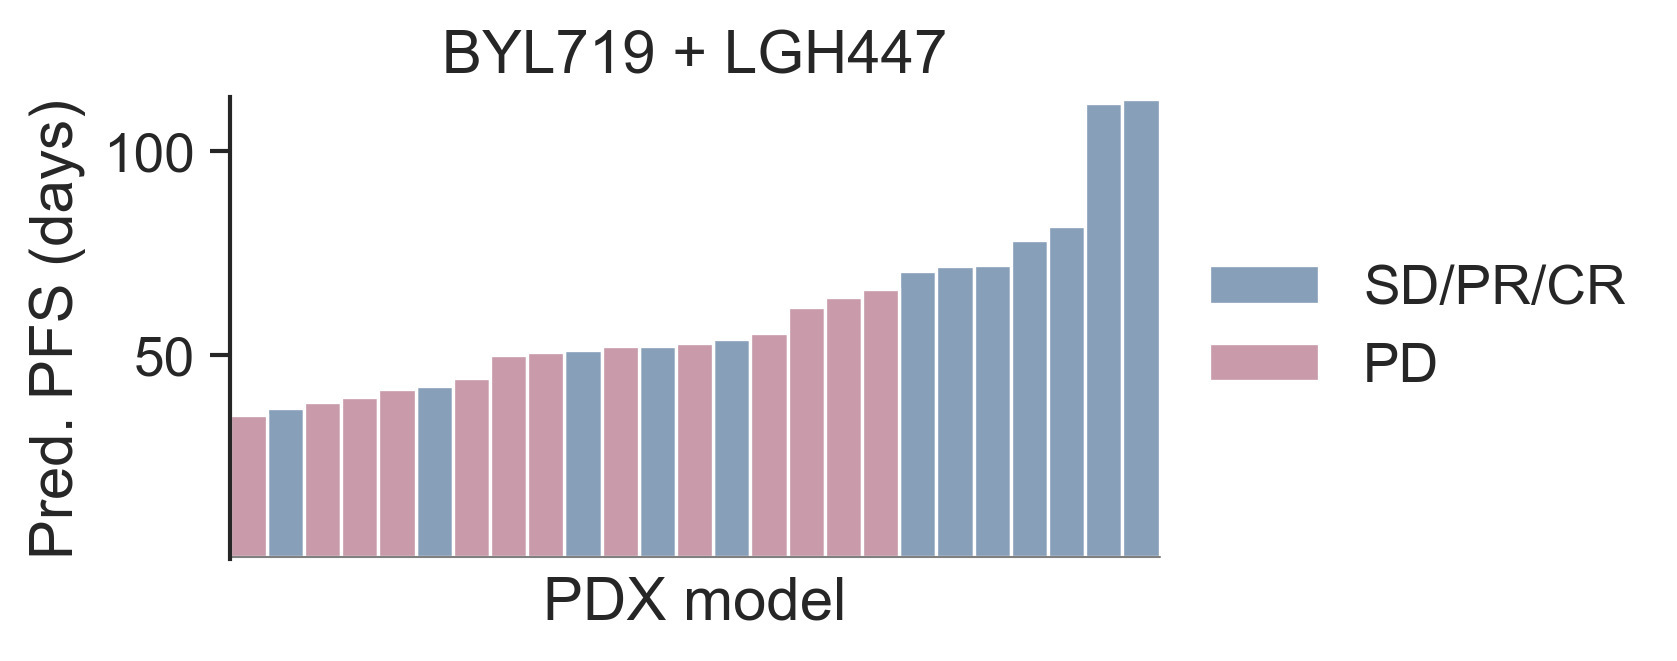

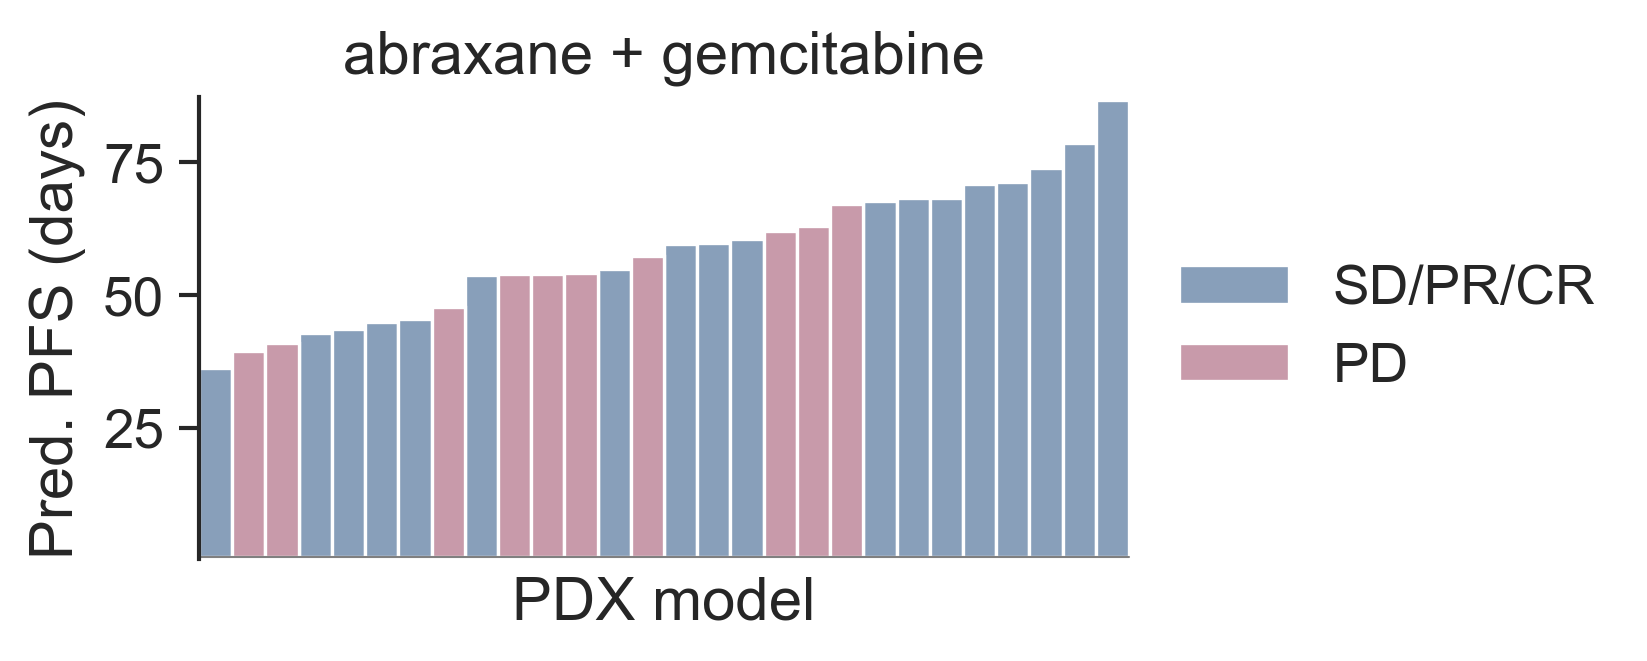

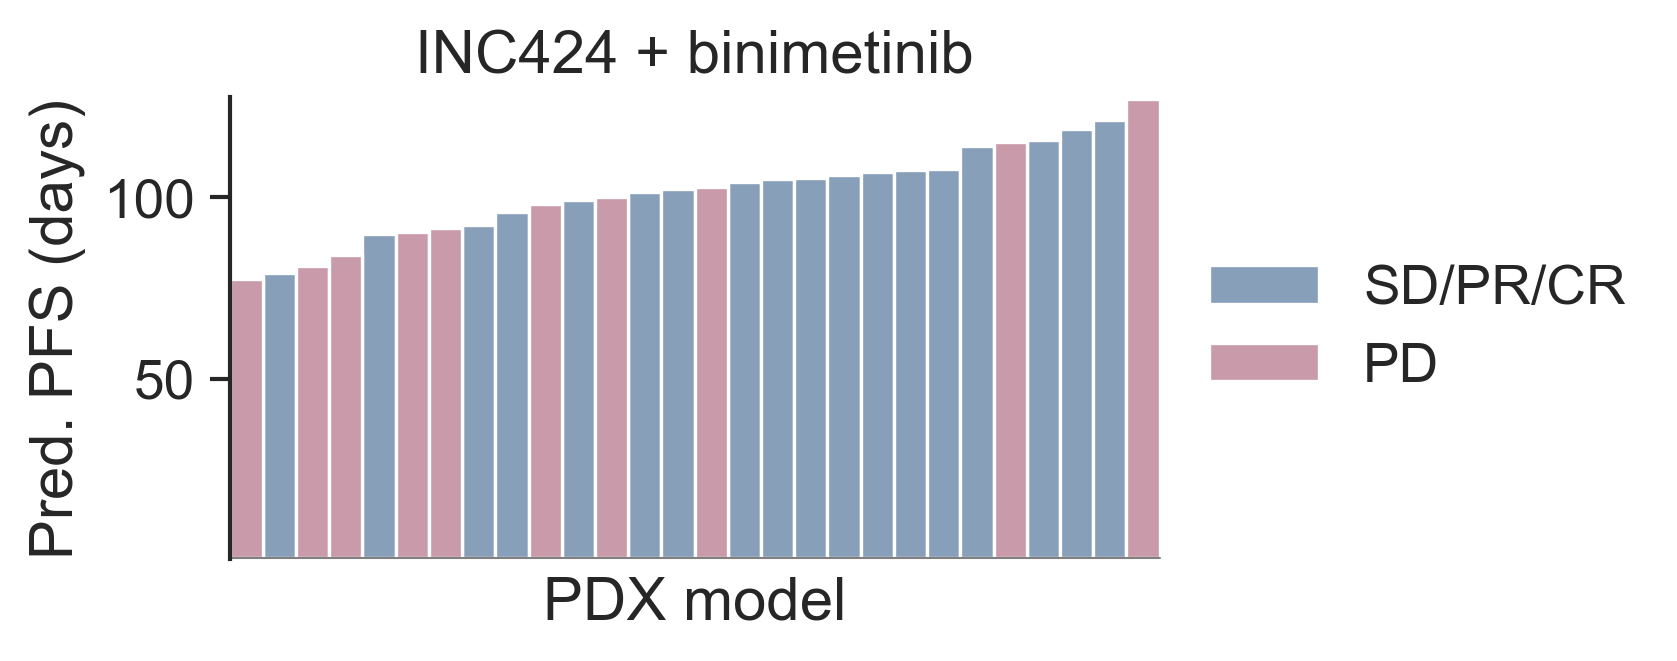

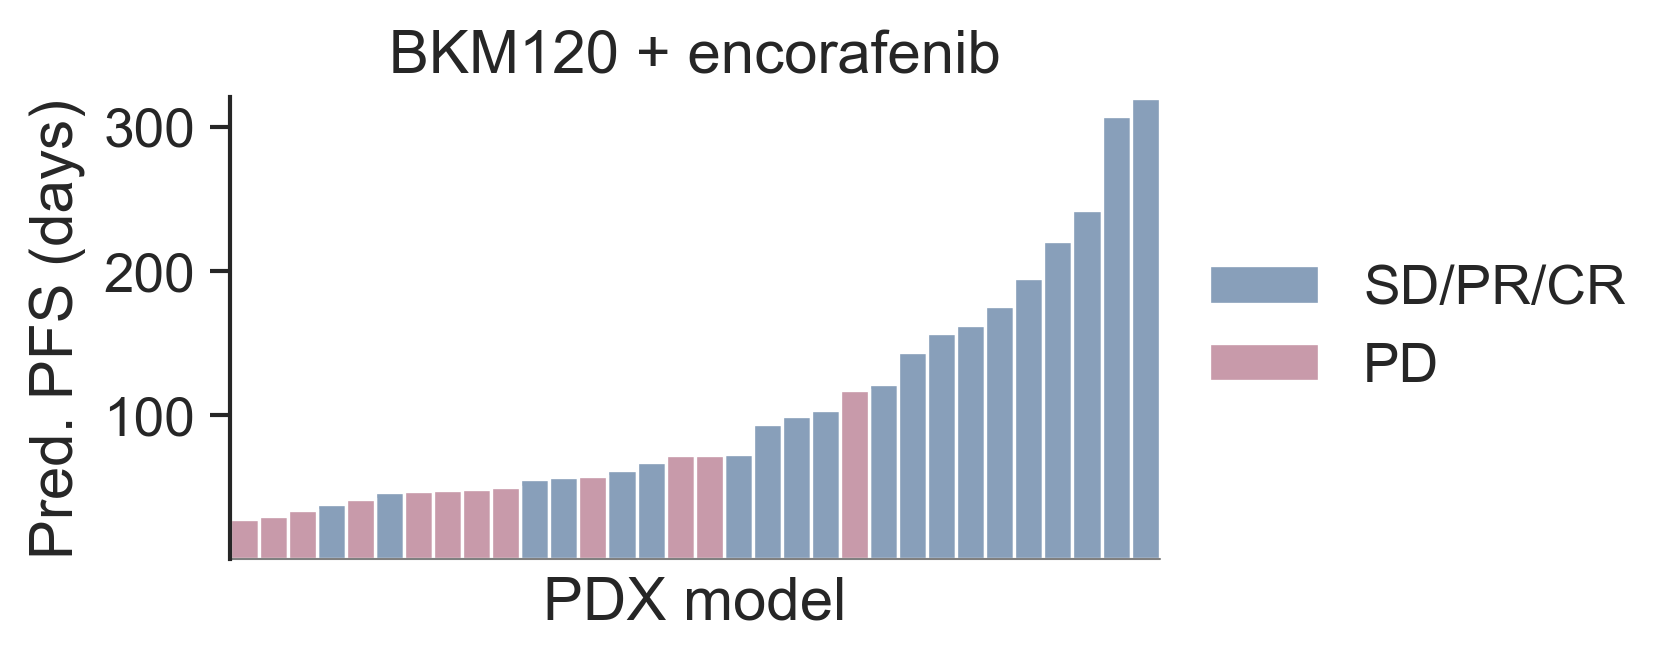

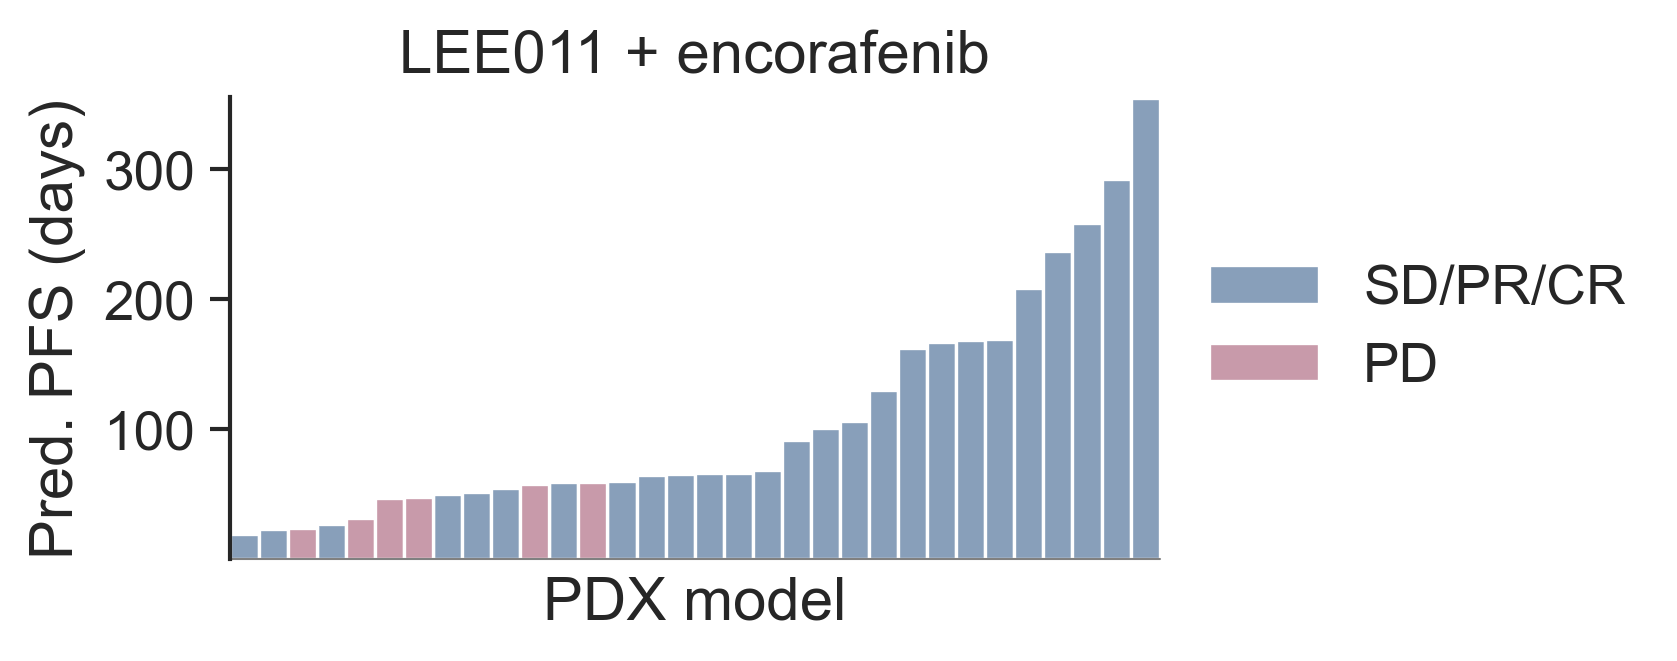

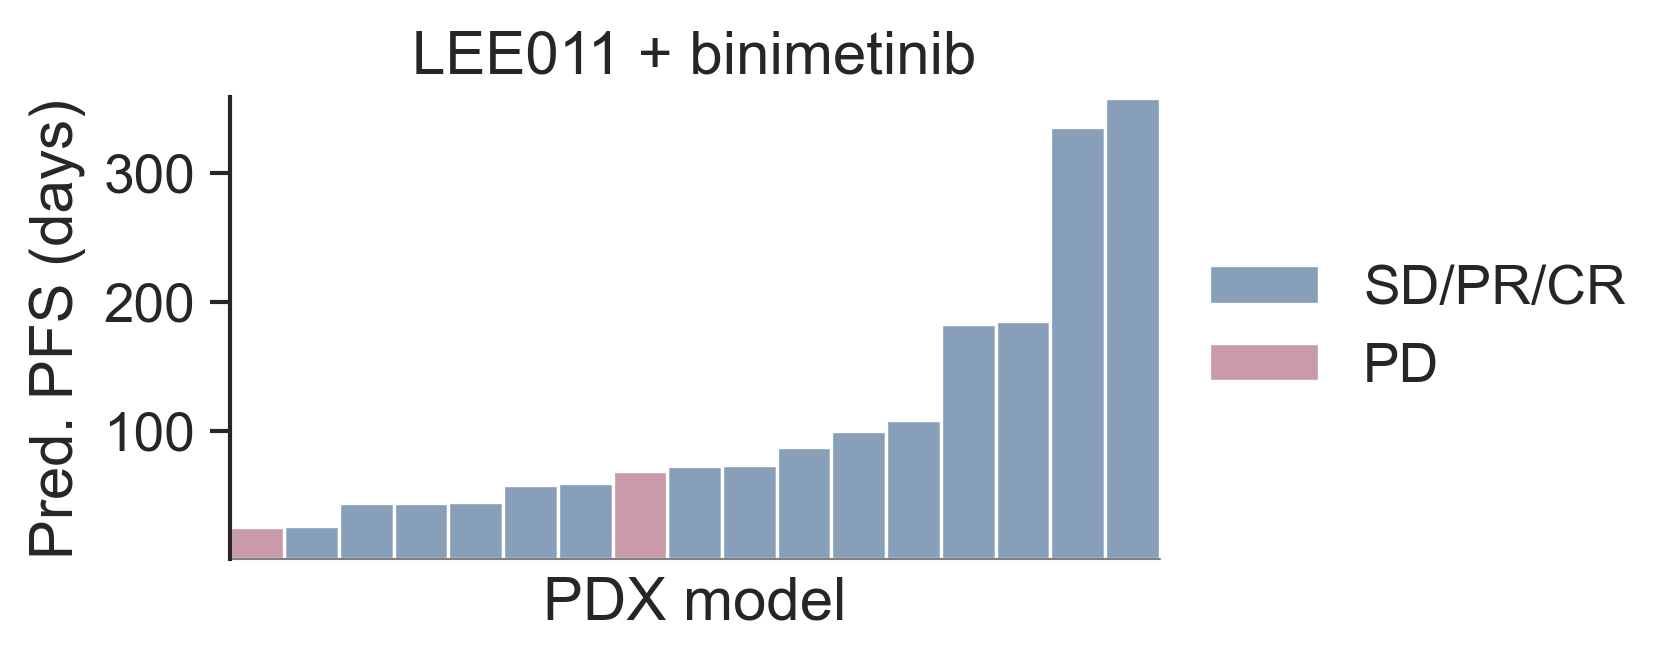

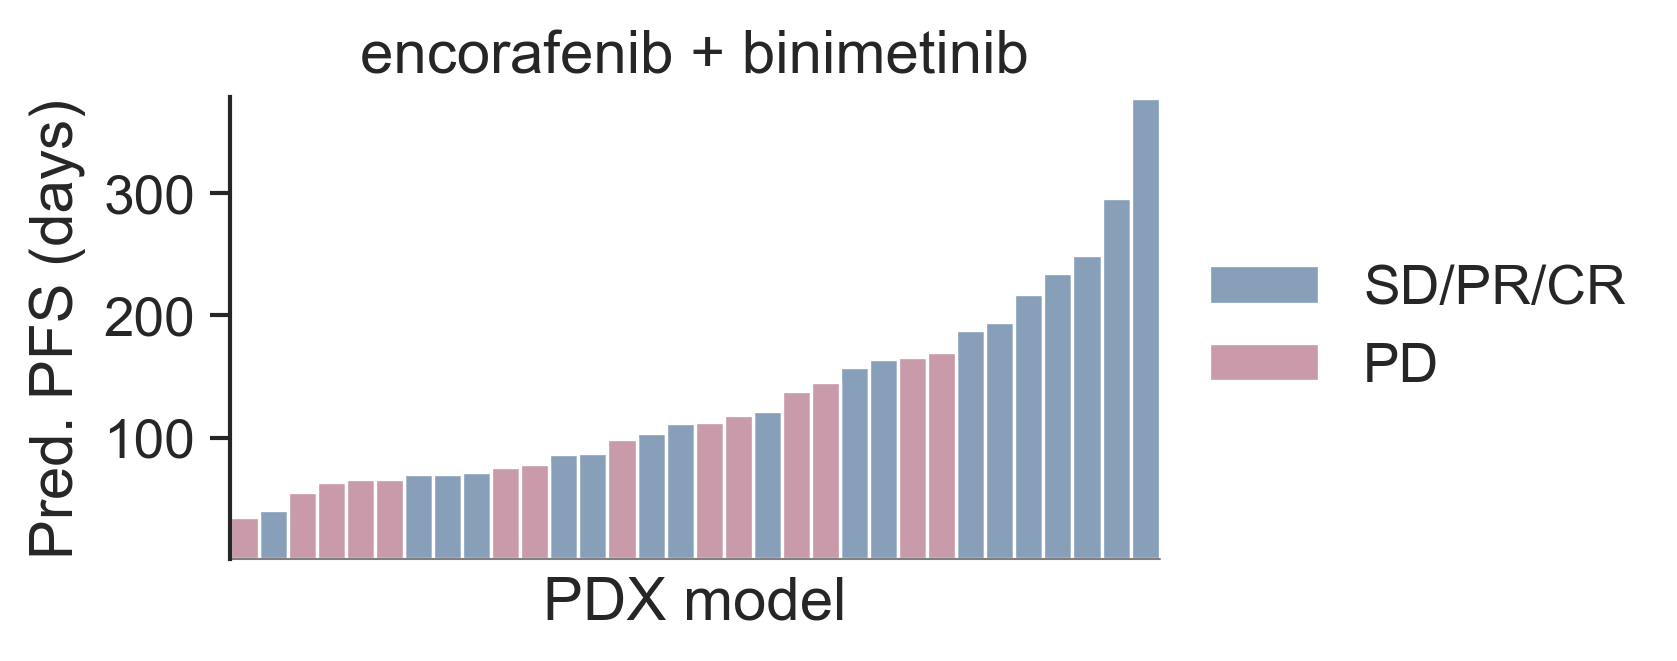

In [ ]:
predicted_outcome = "TimeToDouble"
alternative_outcome = "BestResponseCategory"
for drug_pair, dct in all_drug_pairs_patient_scores_pfs_target.items():
    patients = list(dct.keys())
    pred_scores = list(dct.values())
    alternative_scores = X_metadata[["Model", "Treatment", alternative_outcome]].set_index(["Model", "Treatment"]).loc[(patients, drug_pair), alternative_outcome]
    plot_data = pd.DataFrame.from_dict({
        "Model": patients,
        f"Predicted {predicted_outcome}": pred_scores,
        f"Ground truth {alternative_outcome}": ["PD" if score == "PD" else "SD/PR/CR" for score in alternative_scores],
    })

    fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

    sns.barplot(plot_data, x="Model", y=f"Predicted {predicted_outcome}", hue=f"Ground truth {alternative_outcome}", width=1.0, 
                order=plot_data.sort_values(f"Predicted {predicted_outcome}")["Model"], ax=ax, palette={"PD":"#d092a7", "SD/PR/CR":"#809ec2"},
                hue_order=["SD/PR/CR", "PD"]
               )
    # ax.axhline(np.log(1+1), color="k", clip_on=False)

    log2 = np.log(2)
    ax.set_ylim(min(min(plot_data[f"Predicted {predicted_outcome}"]), log2) - 0.5, max(max(plot_data[f"Predicted {predicted_outcome}"]), log2) + 0.5)

    # Adjust bar positions
    for bar in ax.patches:
        bar_height = bar.get_height()
        if bar_height >= 0:
            bar.set_y(log2)
            bar.set_height(bar_height - log2)
        else:
            bar.set_y(log2 + bar_height)
            bar.set_height(-bar_height + log2)
        # bar.set_edgecolor(bar.get_facecolor())

    # Add a horizontal line at log(2)
    ax.axhline(y=log2, color='gray', linestyle='-', lw=0.5, clip_on=False)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title=None)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.title(drug_pair)
    plt.xlabel("PDX model")
    plt.ylabel("Pred. PFS (days)")
    sns.despine(bottom=True)
    
    plt.savefig(f"fig7_pdx_perf_histogram_{drug_pair}.svg", format="svg", dpi=300)
    plt.show()

    # fig.canvas.draw()